# Time Series Forecasting System
Time Series is a big component of our everyday lives. They are in fact used in medicine (EEG analysis), finance (Stock Prices) and electronics (Sensor Data Analysis). Many Machine Learning models have been created in order to tackle these types of tasks, two examples are ARIMA (AutoRegressive Integrated Moving Average) models and RNNs (Recurrent Neural Networks).


# Data Source

For Time series analysis, we are going to deal with Stock market Analysis. This dataset is based US-based stocks daily price and volume data.
Dataset taken for analysis is IBM stock market data from 2006-01-01 to 2018-01-01.

Below are the key fields in the dataset:

__`Date, Open, High, Low, Close, Volume, Name`__

# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Data

In [2]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv.zip")
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [3]:
print(df.shape)
print(df.columns)

(3020, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Name'], dtype='object')


In [4]:
# Cleaning up the data
df.isnull().values.any()
df = df.dropna()
df.shape

(3019, 7)

In [5]:
df.index = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2006-01-03,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


# Note
This dataset is composed of different features.We will just examine the “Open” stock prices feature. This same analysis can be repeated for most of the other features.

# Visualization

### Visualizing the High and Low prices of IBM

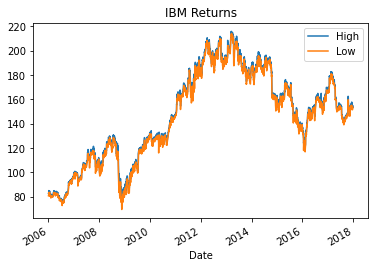

In [6]:
dr = df[['High', 'Low']]
dr.plot()
plt.title('IBM Returns');

### Q1: Visualize the Open and Close prices of IBM

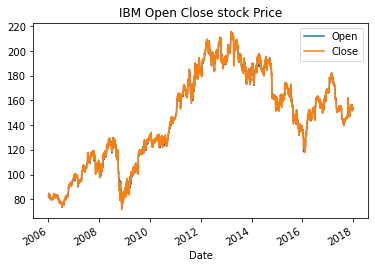

In [7]:
droc = df[['Open', 'Close']]
droc.plot()
plt.title('IBM Open Close stock Price');

### Q2: Visualize the Open and Close Cumulative Prices of IBM

Text(0.5, 1.0, 'IBM Open/Close Cumulative Prices')

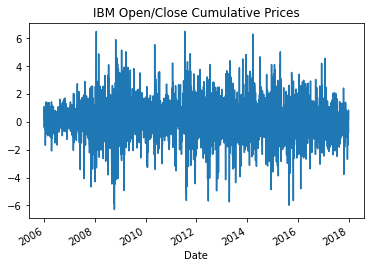

In [8]:
opc = df['Close']-df['Open']
opc.plot()
plt.title('IBM Open/Close Cumulative Prices')

####  Before we start working on Time Series forecasting, Let's analyse the autocorrelation plot of the “Open” feature with respect to a few lag values

### Auto-correlation plot with Lag 1

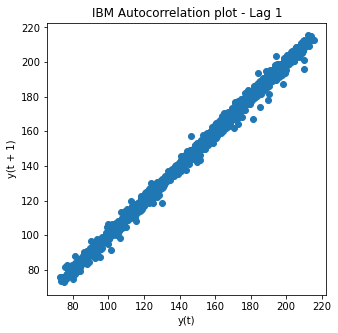

In [9]:
# START_CODE_HERE - plot the Autocorrelation plot for feature 'Open'
from pandas.plotting import lag_plot

plt.figure(figsize=(5,5))
lag_plot(df['Open'], lag=1)
plt.title('IBM Autocorrelation plot - Lag 1');
# END_CODE_HERE

### Q3: Visualize the Auto-Correlation plot for IBM Open prices with Lag 5 

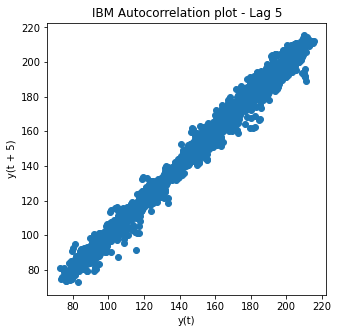

In [10]:
plt.figure(figsize=(5,5))
lag_plot(df['Open'], lag=5)
plt.title('IBM Autocorrelation plot - Lag 5');

We see a definite linear trend in the auto-correlation plot telling us there is some correlation in prices with respect to prices from previous 1 / 5 days of lag which sets up the stage of forecasting future prices based on past price data 

## Build Train-Test Datasets

#### Now, Let's divide the data into a training and test set. Once done so, we can plot both on the same figure in order to get a feeling of how does our Time Series looks like

In [11]:
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]

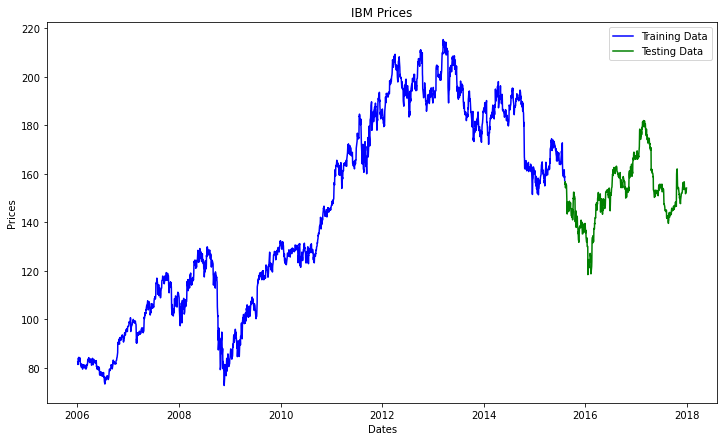

In [12]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data')
plt.plot(test_data['Open'], 'green', label='Testing Data')
plt.legend();

# ARIMA (AutoRegressive Integrated Moving Average)

The acronym of ARIMA stands for:

AutoRegressive(AR) = the model takes advantage of the connection between a predefined number of lagged observations and the current one.

Integrated(I) = differencing between raw observations (eg. subtracting observations at different time steps).

Moving Average(MA) = the model takes advantage of the relationship between the residual error and the observations.

The ARIMA model makes use of three main parameters (p,d,q). These are:

p = number of lag observations.

d = the degree of differencing.

q = the size of the moving average window.



## Understaning the ARIMA Model

### the ARIMA parameters - used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q. You have already learnt a fair bit of this in the curriculum but following is a brief refresher.

__p:__ is the parameter associated with the auto-regressive aspect of the model, which incorporates past values. For example, forecasting that if it rained a lot over the past few days, you state its likely that it will rain tomorrow as well.

__d:__ is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. You can imagine an example of this as forecasting that the amount of rain tomorrow will be similar to the amount of rain today, if the daily amounts of rain have been similar over the past few days.

__q:__ is the parameter associated with the moving average part of the model.

### Approach to determine the parameters
There are many ways to choose these values statistically, such as looking at auto-correlation plots, correlation plots, domain experience, etc.

Another approach is to perform a grid search over multiple values of p,d,q using some sort of performance criteria. The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models.


In this exercise, we will look into the statistical method of getting these values from auto-correlation and correlation plots.

### Stationarity of the data - Determine the d value

Stationarity typically indicates various statistical measures of the time series do not change over time. Thus, a time series is stationary when its mean, variance and auto-correlation, etc., are constant over time. 

Most time-series forecasting models typically perform well when the series is stationary and hence it is important to find out if your time-series dataset is stationary. 

ARIMAs that include differencing (i.e., d > 0) assume that the data becomes stationary after differencing. This is called difference-stationary. 

Auto-correlation plots are an easy way to determine whether your time series is sufficiently stationary for modeling. 

If the plot does not appear relatively stationary, your model will likely need a differencing term. 

The Augmented Dickey-Fuller test is an important statistical test which we will use to prove if the series is stationary or not and take necessary steps in case it is not stationary.

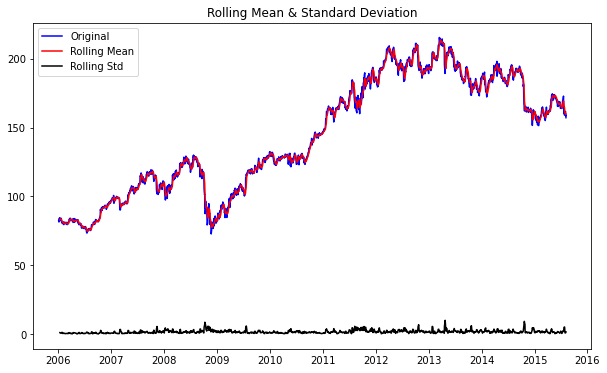

In [13]:
window = 7
train_series = train_data['Open']

#Determing rolling statistics
rolmean = train_series.rolling(window).mean()
rolstd = train_series.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_series, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation');
    

In [14]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(train_series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                   -1.487786
p-value                           0.539545
#Lags Used                        7.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

If the p-value is small beyond a specific significance level threshold, let's consider that to be a standard value of 0.05, then we can say the series is stationary. F

rom the above statistics, we can observe that the p-value is 0.539 which proves that our series is not stationary.

To get stationary data, there are many techniques. We can use log, differencing and so on. Let's use a first order differencing here.

### Q4: Apply a first order differencing on the training data

Hint: Check out the __`diff()`__ function in pandas and try using it on the __`train_series`__ dataset

In [15]:
train_diff = train_data['Open'].diff()
train_diff = train_diff.dropna(inplace = False)
type(train_diff)

pandas.core.series.Series

### Q5: Visualize Rolling statistics for differenced train data

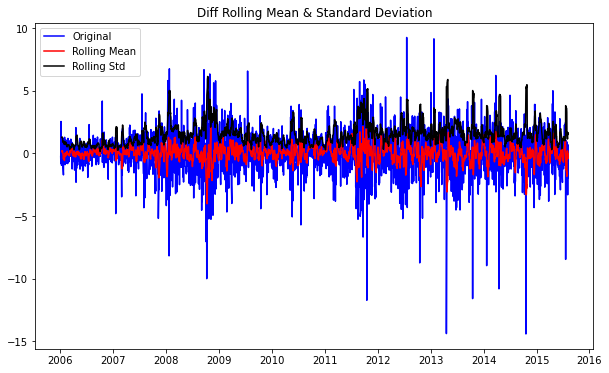

In [16]:
#Determing rolling statistics
rolmean = train_diff.rolling(window).mean()
rolstd = train_diff.rolling(window).std()

#Plot rolling statistics:
fig = plt.figure(figsize=(10, 6))
orig = plt.plot(train_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Diff Rolling Mean & Standard Deviation');

### Q6: Compute AD-Fuller Stats for differenced train data

In [17]:
# from statsmodels.tsa.stattools import adfuller

dfDifftest = adfuller(train_diff, autolag='AIC')
dfDiffoutput = pd.Series(dfDifftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dfDifftest[4].items():
    dfDiffoutput['Critical Value (%s)'%key] = value
dfDiffoutput

Test Statistic                  -20.324277
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    2407.000000
Critical Value (1%)              -3.433070
Critical Value (5%)              -2.862742
Critical Value (10%)             -2.567410
dtype: float64

After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

### ACF Plots (Auto Correlation Function):
ACF is an auto-correlation function which gives us correlation of any series with its lagged values(previous timestep values).

ACF plot describes the correlation of the current value with the previous lagged values(specified by *lags*).

For example, how the dependency chain is followed as direct dependency .... $S_{t-2} --> S_{t-1} --> S_t$*

Also, ACF finds correlation between $S_{t-2} --> S_t$ (indirect dependency).

* --> = represents dependency

#### Limitation: 
ACF is not very accurate as indirect dependency is affected by direct dependency and so the plots are always above the confidence band(as shown below).

### PACF Plots: Pearson Auto Correlation Function:
PACF plots models the indirect dependencies and is not affected by the direct dependencies.

$S_{t-2} --> S_t$

From the below example we can see how today's value is affected by the last 10 days. 

The points that lie inside the blue confidence band do not correlate with or affect today's value. In ACF, we saw that all values are above the confidence band(as $S_{t-2} --> S{t}$ is affected by $S_{t-1} --> S_t$), which is not a good representation of the correlation.


In PACF, indirect dependencies are modelled well.

## ACF and PACF - AR and MA Intuition
The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

### Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

### Plot ACF and PACF on the original train series

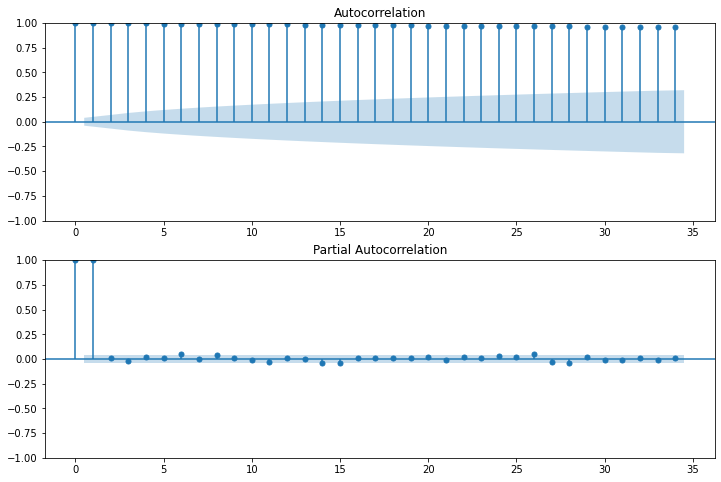

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_series, ax=ax[0]); # 
plot_pacf(train_series, ax=ax[1]);

### Q7: Plot ACF and PACF on the differenced train series

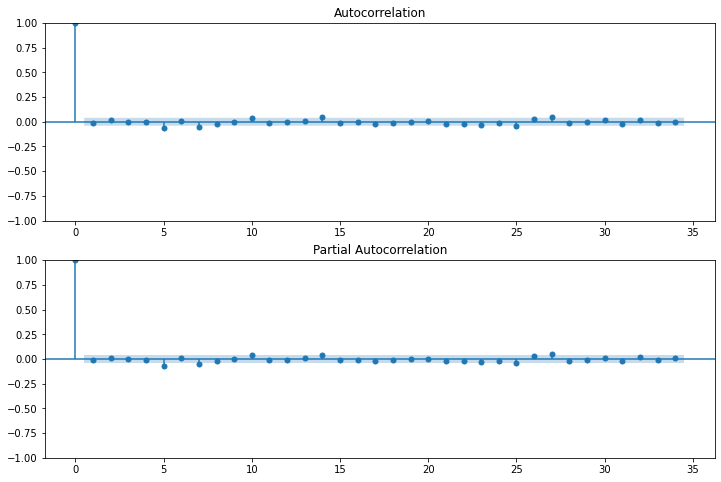

In [19]:
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train_diff, ax=ax[0]); # 
plot_pacf(train_diff, ax=ax[1]);

# How to determine p, d, q

It's easy to determine d. In our case, we see the first order differencing make the ts stationary. Hence d = 1

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 5 lags the AR is significant. Which means, we can use AR = 5 i.e, p = 5

To avoid the potential for incorrectly specifying the MA order to be too high we set MA = 0 i.e q = 0 by taking a look at the ACF plot though we do have a value of 5 which is significant considering the interval but we start off with the first lag value i.e q = 0.

Hence:

- p=5
- d=1
- q=0

# Evaluation of ARIMA Model

In order to evaluate the ARIMA model,we can use two different error functions:

- Mean Squared Error (MSE)
- Symmetric Mean Absolute Percentage Error (SMAPE)

SMAPE is commonly used as an accuracy measure based on relative errors

### SMAPE

![](imgs/smape.png)

SMAPE is not currently supported in Scikit-learn as a loss function, therefore we first create this function.

In [20]:
def smape_kun(y_true, y_pred):
    # START_CODE_HERE
    return np.mean((np.abs(y_pred - y_true) * 200 / (np.abs(y_pred) + np.abs(y_true))))
    # END_CODE_HERE

### Q8: Difference the Test Series

In [21]:
test_series = test_data['Open']
test_diff = test_series.diff()
test_diff = test_diff.dropna(inplace = False)

### Q9: Train and Forecast using ARIMA Model by filling in the necessary blocks

Note: Here we will use a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model.
Of course this is not the only way for forecasting and you can do it in multiple ways e.g just use train data to forecast, use a window of days to forecast including test data and so on.

In [22]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [24]:
%%time 

history = [x for x in train_diff]

predictions = list()
for t in range(len(test_diff)):

    # START_CODE_HERE - call the ARIMA Method with history and params
    print("t=", t)
    if (t>0):
        tdt = train_series.append(test_series[:t-1])
    else:
        tdt = train_series
    model = ARIMA(tdt, order=(5,1,0))  # initialize the model with history and right order of parameters
    model_fit = model.fit()   # fit the model
    # END_CODE_HERE
    print("starting date=", test_diff.index.values[t])
    # output = model_fit.predict()  # use forecast on the fitted model
    output = model_fit.predict()  # use forecast on the fitted model
    print("predicted")
    print(output)
    print(type(output))
    yhat = output[0]
    print("yhat=",yhat)
    predictions.append(yhat)
    obs = test_series[t]
    history.append(obs)
    if t % 100 == 0:
      print('Test Series Point: {}\tPredicted={}, Expected={}'.format(t, yhat, obs))

t= 0


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203100
2006-01-06     81.406060
2006-01-09     83.908070
                 ...    
2015-07-31    160.439442
2015-08-03    161.541685
2015-08-04    161.647358
2015-08-05    158.434389
2015-08-06    159.003620
Name: predicted_mean, Length: 2415, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
Test Series Point: 0	Predicted=0.0, Expected=155.89
t= 1


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203100
2006-01-06     81.406060
2006-01-09     83.908070
                 ...    
2015-07-31    160.439442
2015-08-03    161.541685
2015-08-04    161.647358
2015-08-05    158.434389
2015-08-06    159.003620
Name: predicted_mean, Length: 2415, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 2


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203023
2006-01-06     81.405853
2006-01-09     83.908796
                 ...    
2015-08-03    161.542240
2015-08-04    161.647473
2015-08-05    158.433816
2015-08-06    159.004188
2015-08-07    157.109395
Name: predicted_mean, Length: 2416, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 3


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203052
2006-01-06     81.406004
2006-01-09     83.908649
                 ...    
2015-08-04    161.647264
2015-08-05    158.434111
2015-08-06    159.004505
2015-08-07    157.109200
2015-08-10    155.877703
Name: predicted_mean, Length: 2417, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 4


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203079
2006-01-06     81.406053
2006-01-09     83.908201
                 ...    
2015-08-05    158.434734
2015-08-06    159.004106
2015-08-07    157.109069
2015-08-10    155.878090
2015-08-11    156.957170
Name: predicted_mean, Length: 2418, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 5


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203043
2006-01-06     81.405991
2006-01-09     83.908641
                 ...    
2015-08-06    159.005227
2015-08-07    157.107731
2015-08-10    155.877004
2015-08-11    156.957806
2015-08-12    155.950435
Name: predicted_mean, Length: 2419, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 6


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203128
2006-01-06     81.406308
2006-01-09     83.907862
                 ...    
2015-08-07    157.107248
2015-08-10    155.878637
2015-08-11    156.958517
2015-08-12    155.950562
2015-08-13    154.407990
Name: predicted_mean, Length: 2420, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 7


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203189
2006-01-06     81.406442
2006-01-09     83.907052
                 ...    
2015-08-10    155.879008
2015-08-11    156.957162
2015-08-12    155.951178
2015-08-13    154.408139
2015-08-14    156.089640
Name: predicted_mean, Length: 2421, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 8


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203196
2006-01-06     81.406450
2006-01-09     83.906960
                 ...    
2015-08-11    156.957075
2015-08-12    155.951357
2015-08-13    154.408088
2015-08-14    156.089499
2015-08-17    154.988721
Name: predicted_mean, Length: 2422, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 9


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203193
2006-01-06     81.406452
2006-01-09     83.906997
                 ...    
2015-08-12    155.951339
2015-08-13    154.408284
2015-08-14    156.089504
2015-08-17    154.988575
2015-08-18    155.245269
Name: predicted_mean, Length: 2423, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 10


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203196
2006-01-06     81.406465
2006-01-09     83.906962
                 ...    
2015-08-13    154.408312
2015-08-14    156.089231
2015-08-17    154.988645
2015-08-18    155.245476
2015-08-19    155.610225
Name: predicted_mean, Length: 2424, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 11


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203175
2006-01-06     81.406420
2006-01-09     83.907257
                 ...    
2015-08-14    156.090515
2015-08-17    154.987755
2015-08-18    155.245415
2015-08-19    155.611703
2015-08-20    155.045675
Name: predicted_mean, Length: 2425, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 12


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203072
2006-01-06     81.406077
2006-01-09     83.908259
                 ...    
2015-08-17    154.987730
2015-08-18    155.245227
2015-08-19    155.611542
2015-08-20    155.045895
2015-08-21    152.833706
Name: predicted_mean, Length: 2426, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 13


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202752
2006-01-06     81.404449
2006-01-09     83.909580
                 ...    
2015-08-18    155.244305
2015-08-19    155.611748
2015-08-20    155.046277
2015-08-21    152.830046
2015-08-24    151.458364
Name: predicted_mean, Length: 2427, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 14


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203615
2006-01-06     81.407293
2006-01-09     83.901578
                 ...    
2015-08-19    155.611117
2015-08-20    155.047519
2015-08-21    152.837953
2015-08-24    151.464282
2015-08-25    143.553303
Name: predicted_mean, Length: 2428, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 15


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-08-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203930
2006-01-06     81.407585
2006-01-09     83.896343
                 ...    
2015-08-20    155.048252
2015-08-21    152.839886
2015-08-24    151.459333
2015-08-25    143.557676
2015-08-26    146.774897
Name: predicted_mean, Length: 2429, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 16


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204290
2006-01-06     81.408174
2006-01-09     83.892550
                 ...    
2015-08-21    152.842395
2015-08-24    151.457914
2015-08-25    143.576087
2015-08-26    146.763745
2015-08-27    144.424592
Name: predicted_mean, Length: 2430, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 17


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204406
2006-01-06     81.408463
2006-01-09     83.891294
                 ...    
2015-08-24    151.458181
2015-08-25    143.579380
2015-08-26    146.759101
2015-08-27    144.427688
2015-08-28    148.478366
Name: predicted_mean, Length: 2431, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 18


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204373
2006-01-06     81.408514
2006-01-09     83.891913
                 ...    
2015-08-25    143.579080
2015-08-26    146.763828
2015-08-27    144.421181
2015-08-28    148.483337
2015-08-31    148.378511
Name: predicted_mean, Length: 2432, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 19


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204360
2006-01-06     81.408396
2006-01-09     83.892223
                 ...    
2015-08-26    146.762947
2015-08-27    144.432123
2015-08-28    148.474491
2015-08-31    148.392449
2015-09-01    147.125265
Name: predicted_mean, Length: 2433, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 20


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204327
2006-01-06     81.408289
2006-01-09     83.892528
                 ...    
2015-08-27    144.431613
2015-08-28    148.476467
2015-08-31    148.390663
2015-09-01    147.126343
2015-09-02    145.114410
Name: predicted_mean, Length: 2434, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 21


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204332
2006-01-06     81.408436
2006-01-09     83.892857
                 ...    
2015-08-28    148.477270
2015-08-31    148.381216
2015-09-01    147.129724
2015-09-02    145.111659
2015-09-03    144.407880
Name: predicted_mean, Length: 2435, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 22


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204397
2006-01-06     81.408640
2006-01-09     83.892065
                 ...    
2015-08-31    148.379442
2015-09-01    147.132090
2015-09-02    145.111887
2015-09-03    144.408184
2015-09-04    146.090896
Name: predicted_mean, Length: 2436, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 23


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204447
2006-01-06     81.408746
2006-01-09     83.891433
                 ...    
2015-09-01    147.132777
2015-09-02    145.110900
2015-09-03    144.407760
2015-09-04    146.090815
2015-09-08    144.664333
Name: predicted_mean, Length: 2437, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 24


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204333
2006-01-06     81.408528
2006-01-09     83.892816
                 ...    
2015-09-02    145.111931
2015-09-03    144.405011
2015-09-04    146.091002
2015-09-08    144.663431
2015-09-09    145.968337
Name: predicted_mean, Length: 2438, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 25


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204586
2006-01-06     81.409455
2006-01-09     83.890480
                 ...    
2015-09-03    144.406600
2015-09-04    146.088551
2015-09-08    144.665392
2015-09-09    145.968358
2015-09-10    148.721984
Name: predicted_mean, Length: 2439, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 26


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204589
2006-01-06     81.409462
2006-01-09     83.890437
                 ...    
2015-09-04    146.088516
2015-09-08    144.665441
2015-09-09    145.968318
2015-09-10    148.721946
2015-09-11    145.874029
Name: predicted_mean, Length: 2440, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 27


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204590
2006-01-06     81.409610
2006-01-09     83.890659
                 ...    
2015-09-08    144.664200
2015-09-09    145.970363
2015-09-10    148.720872
2015-09-11    145.872530
2015-09-14    145.932431
Name: predicted_mean, Length: 2441, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 28


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204616
2006-01-06     81.409698
2006-01-09     83.890339
                 ...    
2015-09-09    145.970823
2015-09-10    148.719893
2015-09-11    145.873380
2015-09-14    145.932960
2015-09-15    147.249525
Name: predicted_mean, Length: 2442, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 29


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204642
2006-01-06     81.409713
2006-01-09     83.889906
                 ...    
2015-09-10    148.719148
2015-09-11    145.875824
2015-09-14    145.930874
2015-09-15    147.248582
2015-09-16    146.470326
Name: predicted_mean, Length: 2443, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 30


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204637
2006-01-06     81.409703
2006-01-09     83.889951
                 ...    
2015-09-11    145.875721
2015-09-14    145.931022
2015-09-15    147.248498
2015-09-16    146.470184
2015-09-17    147.989529
Name: predicted_mean, Length: 2444, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 31


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204648
2006-01-06     81.409822
2006-01-09     83.890021
                 ...    
2015-09-14    145.932004
2015-09-15    147.246760
2015-09-16    146.470772
2015-09-17    147.989995
2015-09-18    148.105984
Name: predicted_mean, Length: 2445, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 32


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204610
2006-01-06     81.409705
2006-01-09     83.890441
                 ...    
2015-09-15    147.247273
2015-09-16    146.470157
2015-09-17    147.990372
2015-09-18    148.106145
2015-09-21    145.995182
Name: predicted_mean, Length: 2446, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 33


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204592
2006-01-06     81.409595
2006-01-09     83.890486
                 ...    
2015-09-16    146.470964
2015-09-17    147.990041
2015-09-18    148.106258
2015-09-21    145.995265
2015-09-22    145.404220
Name: predicted_mean, Length: 2447, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 34


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204583
2006-01-06     81.409564
2006-01-09     83.890525
                 ...    
2015-09-17    147.990332
2015-09-18    148.106218
2015-09-21    145.995248
2015-09-22    145.404190
2015-09-23    144.544935
Name: predicted_mean, Length: 2448, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 35


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204570
2006-01-06     81.409484
2006-01-09     83.890515
                 ...    
2015-09-18    148.106901
2015-09-21    145.994913
2015-09-22    145.404403
2015-09-23    144.544537
2015-09-24    144.203591
Name: predicted_mean, Length: 2449, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 36


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-09-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204706
2006-01-06     81.409946
2006-01-09     83.889326
                 ...    
2015-09-21    145.994863
2015-09-22    145.405261
2015-09-23    144.544632
2015-09-24    144.204414
2015-09-25    142.770427
Name: predicted_mean, Length: 2450, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 37


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204810
2006-01-06     81.410216
2006-01-09     83.888120
                 ...    
2015-09-22    145.405165
2015-09-23    144.544795
2015-09-24    144.204188
2015-09-25    142.770676
2015-09-28    145.515121
Name: predicted_mean, Length: 2451, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 38


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204721
2006-01-06     81.410190
2006-01-09     83.889546
                 ...    
2015-09-23    144.544485
2015-09-24    144.204167
2015-09-25    142.769564
2015-09-28    145.517095
2015-09-29    144.556222
Name: predicted_mean, Length: 2452, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 39


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204841
2006-01-06     81.410642
2006-01-09     83.888351
                 ...    
2015-09-24    144.204768
2015-09-25    142.770434
2015-09-28    145.516019
2015-09-29    144.555395
2015-09-30    142.047842
Name: predicted_mean, Length: 2453, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 40


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204765
2006-01-06     81.410524
2006-01-09     83.889517
                 ...    
2015-09-25    142.770509
2015-09-28    145.517622
2015-09-29    144.553930
2015-09-30    142.046128
2015-10-01    143.707148
Name: predicted_mean, Length: 2454, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 41


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204982
2006-01-06     81.411459
2006-01-09     83.887645
                 ...    
2015-09-28    145.516525
2015-09-29    144.551263
2015-09-30    142.052553
2015-10-01    143.710460
2015-10-02    145.113630
Name: predicted_mean, Length: 2455, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 42


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205567
2006-01-06     81.413087
2006-01-09     83.880896
                 ...    
2015-09-29    144.556094
2015-09-30    142.062767
2015-10-01    143.700135
2015-10-02    145.108417
2015-10-05    141.270351
Name: predicted_mean, Length: 2456, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 43


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205095
2006-01-06     81.412060
2006-01-09     83.886671
                 ...    
2015-09-30    142.061223
2015-10-01    143.710253
2015-10-02    145.103452
2015-10-05    141.260214
2015-10-06    145.814573
Name: predicted_mean, Length: 2457, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 44


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204988
2006-01-06     81.411538
2006-01-09     83.887428
                 ...    
2015-10-01    143.710329
2015-10-02    145.107152
2015-10-05    141.257556
2015-10-06    145.812882
2015-10-07    148.946314
Name: predicted_mean, Length: 2458, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 45


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.204999
2006-01-06     81.411602
2006-01-09     83.887442
                 ...    
2015-10-02    145.106971
2015-10-05    141.256912
2015-10-06    145.813351
2015-10-07    148.946488
2015-10-08    149.982052
Name: predicted_mean, Length: 2459, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 46


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205054
2006-01-06     81.411715
2006-01-09     83.886432
                 ...    
2015-10-05    141.257615
2015-10-06    145.818772
2015-10-07    148.943195
2015-10-08    149.979650
2015-10-09    149.993668
Name: predicted_mean, Length: 2460, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 47


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205025
2006-01-06     81.411629
2006-01-09     83.886718
                 ...    
2015-10-06    145.819216
2015-10-07    148.943961
2015-10-08    149.979628
2015-10-09    149.993540
2015-10-12    152.037025
Name: predicted_mean, Length: 2461, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 48


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205019
2006-01-06     81.411740
2006-01-09     83.887112
                 ...    
2015-10-07    148.940184
2015-10-08    149.978166
2015-10-09    149.994859
2015-10-12    152.033975
2015-10-13    152.205078
Name: predicted_mean, Length: 2462, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 49


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204962
2006-01-06     81.411550
2006-01-09     83.887772
                 ...    
2015-10-08    149.976198
2015-10-09    149.994264
2015-10-12    152.033753
2015-10-13    152.204835
2015-10-14    150.740211
Name: predicted_mean, Length: 2463, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 50


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205018
2006-01-06     81.411795
2006-01-09     83.887405
                 ...    
2015-10-09    149.996370
2015-10-12    152.034516
2015-10-13    152.204383
2015-10-14    150.740330
2015-10-15    149.609117
Name: predicted_mean, Length: 2464, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 51


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205027
2006-01-06     81.411815
2006-01-09     83.887284
                 ...    
2015-10-12    152.034107
2015-10-13    152.204219
2015-10-14    150.740436
2015-10-15    149.609132
2015-10-16    150.664243
Name: predicted_mean, Length: 2465, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 52


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205020
2006-01-06     81.411823
2006-01-09     83.887403
                 ...    
2015-10-13    152.204048
2015-10-14    150.740604
2015-10-15    149.609612
2015-10-16    150.664265
2015-10-19    150.492894
Name: predicted_mean, Length: 2466, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 53


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204900
2006-01-06     81.411307
2006-01-09     83.888605
                 ...    
2015-10-14    150.737436
2015-10-15    149.610806
2015-10-16    150.670640
2015-10-19    150.492723
2015-10-20    149.972353
Name: predicted_mean, Length: 2467, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 54


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204337
2006-01-06     81.409481
2006-01-09     83.894069
                 ...    
2015-10-15    149.606690
2015-10-16    150.674060
2015-10-19    150.492504
2015-10-20    149.970941
2015-10-21    142.685775
Name: predicted_mean, Length: 2468, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 55


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204448
2006-01-06     81.410223
2006-01-09     83.894062
                 ...    
2015-10-16    150.676153
2015-10-19    150.491045
2015-10-20    149.971374
2015-10-21    142.689812
2015-10-22    140.090030
Name: predicted_mean, Length: 2469, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 56


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204309
2006-01-06     81.409940
2006-01-09     83.896659
                 ...    
2015-10-19    150.493191
2015-10-20    149.968527
2015-10-21    142.687319
2015-10-22    140.096274
2015-10-23    141.749488
Name: predicted_mean, Length: 2470, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 57


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204301
2006-01-06     81.409909
2006-01-09     83.896740
                 ...    
2015-10-20    149.968570
2015-10-21    142.687022
2015-10-22    140.096132
2015-10-23    141.749716
2015-10-26    144.668723
Name: predicted_mean, Length: 2471, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 58


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-10-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204316
2006-01-06     81.410115
2006-01-09     83.897121
                 ...    
2015-10-21    142.686544
2015-10-22    140.102895
2015-10-23    141.752611
2015-10-26    144.663720
2015-10-27    145.298789
Name: predicted_mean, Length: 2472, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 59


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204078
2006-01-06     81.409351
2006-01-09     83.900077
                 ...    
2015-10-22    140.105343
2015-10-23    141.769056
2015-10-26    144.677347
2015-10-27    145.286397
2015-10-28    143.656804
Name: predicted_mean, Length: 2473, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 60


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204515
2006-01-06     81.410834
2006-01-09     83.895947
                 ...    
2015-10-23    141.766279
2015-10-26    144.665238
2015-10-27    145.279861
2015-10-28    143.659268
2015-10-29    137.890428
Name: predicted_mean, Length: 2474, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 61


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204486
2006-01-06     81.410810
2006-01-09     83.896435
                 ...    
2015-10-26    144.665146
2015-10-27    145.278058
2015-10-28    143.658638
2015-10-29    137.890359
2015-10-30    140.060132
Name: predicted_mean, Length: 2475, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 62


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204486
2006-01-06     81.410810
2006-01-09     83.896435
                 ...    
2015-10-27    145.278059
2015-10-28    143.658644
2015-10-29    137.890361
2015-10-30    140.060134
2015-11-02    140.502989
Name: predicted_mean, Length: 2476, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 63


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204494
2006-01-06     81.410832
2006-01-09     83.896406
                 ...    
2015-10-28    143.658535
2015-10-29    137.891581
2015-10-30    140.060732
2015-11-02    140.503402
2015-11-03    140.588644
Name: predicted_mean, Length: 2477, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 64


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204536
2006-01-06     81.410963
2006-01-09     83.895962
                 ...    
2015-10-29    137.891884
2015-10-30    140.056366
2015-11-02    140.502129
2015-11-03    140.587166
2015-11-04    140.403375
Name: predicted_mean, Length: 2478, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 65


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204592
2006-01-06     81.411128
2006-01-09     83.895377
                 ...    
2015-10-30    140.055024
2015-11-02    140.502178
2015-11-03    140.587492
2015-11-04    140.404629
2015-11-05    142.329635
Name: predicted_mean, Length: 2479, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 66


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204502
2006-01-06     81.411093
2006-01-09     83.896899
                 ...    
2015-11-02    140.499100
2015-11-03    140.587890
2015-11-04    140.404635
2015-11-05    142.330812
2015-11-06    141.654266
Name: predicted_mean, Length: 2480, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 67


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204439
2006-01-06     81.410867
2006-01-09     83.897533
                 ...    
2015-11-03    140.587180
2015-11-04    140.404592
2015-11-05    142.331415
2015-11-06    141.654330
2015-11-09    138.621903
Name: predicted_mean, Length: 2481, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 68


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204374
2006-01-06     81.410422
2006-01-09     83.897444
                 ...    
2015-11-04    140.401896
2015-11-05    142.331798
2015-11-06    141.656341
2015-11-09    138.621476
2015-11-10    137.921641
Name: predicted_mean, Length: 2482, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 69


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204438
2006-01-06     81.410637
2006-01-09     83.896930
                 ...    
2015-11-05    142.331788
2015-11-06    141.656553
2015-11-09    138.621601
2015-11-10    137.921961
2015-11-11    135.248137
Name: predicted_mean, Length: 2483, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 70


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204479
2006-01-06     81.410655
2006-01-09     83.896171
                 ...    
2015-11-06    141.657730
2015-11-09    138.621637
2015-11-10    137.921831
2015-11-11    135.247690
2015-11-12    136.122973
Name: predicted_mean, Length: 2484, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 71


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204397
2006-01-06     81.410452
2006-01-09     83.896967
                 ...    
2015-11-09    138.622273
2015-11-10    137.921653
2015-11-11    135.246791
2015-11-12    136.121952
2015-11-13    134.954822
Name: predicted_mean, Length: 2485, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 72


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204339
2006-01-06     81.410211
2006-01-09     83.897432
                 ...    
2015-11-10    137.921854
2015-11-11    135.246213
2015-11-12    136.120472
2015-11-13    134.954280
2015-11-16    133.010855
Name: predicted_mean, Length: 2486, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 73


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204421
2006-01-06     81.410589
2006-01-09     83.897045
                 ...    
2015-11-11    135.246547
2015-11-12    136.121841
2015-11-13    134.957231
2015-11-16    133.011820
2015-11-17    131.968972
Name: predicted_mean, Length: 2487, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 74


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204370
2006-01-06     81.410449
2006-01-09     83.897656
                 ...    
2015-11-12    136.122578
2015-11-13    134.957173
2015-11-16    133.011741
2015-11-17    131.968881
2015-11-18    134.129731
Name: predicted_mean, Length: 2488, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 75


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204343
2006-01-06     81.410263
2006-01-09     83.897695
                 ...    
2015-11-13    134.958598
2015-11-16    133.011791
2015-11-17    131.968700
2015-11-18    134.130066
2015-11-19    134.920654
Name: predicted_mean, Length: 2489, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 76


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204295
2006-01-06     81.410096
2006-01-09     83.898051
                 ...    
2015-11-16    133.012126
2015-11-17    131.968403
2015-11-18    134.129895
2015-11-19    134.921168
2015-11-20    136.301097
Name: predicted_mean, Length: 2490, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 77


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204262
2006-01-06     81.409945
2006-01-09     83.898225
                 ...    
2015-11-17    131.968387
2015-11-18    134.129372
2015-11-19    134.921258
2015-11-20    136.301513
2015-11-23    137.437460
Name: predicted_mean, Length: 2491, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 78


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-11-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204286
2006-01-06     81.410043
2006-01-09     83.898089
                 ...    
2015-11-18    134.129381
2015-11-19    134.921465
2015-11-20    136.301449
2015-11-23    137.437245
2015-11-24    138.347386
Name: predicted_mean, Length: 2492, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 79


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204308
2006-01-06     81.410088
2006-01-09     83.897766
                 ...    
2015-11-19    134.921252
2015-11-20    136.301421
2015-11-23    137.437608
2015-11-24    138.347764
2015-11-25    137.629312
Name: predicted_mean, Length: 2493, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 80


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204313
2006-01-06     81.410096
2006-01-09     83.897710
                 ...    
2015-11-20    136.301439
2015-11-23    137.437563
2015-11-24    138.347606
2015-11-25    137.629249
2015-11-27    138.237092
Name: predicted_mean, Length: 2494, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 81


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204322
2006-01-06     81.410109
2006-01-09     83.897593
                 ...    
2015-11-23    137.437685
2015-11-24    138.347827
2015-11-25    137.629442
2015-11-27    138.237186
2015-11-30    137.938641
Name: predicted_mean, Length: 2495, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 82


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204300
2006-01-06     81.410054
2006-01-09     83.897822
                 ...    
2015-11-24    138.348277
2015-11-25    137.629358
2015-11-27    138.237457
2015-11-30    137.938552
2015-12-01    138.513301
Name: predicted_mean, Length: 2496, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 83


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204264
2006-01-06     81.409913
2006-01-09     83.898131
                 ...    
2015-11-25    137.629347
2015-11-27    138.237360
2015-11-30    137.938581
2015-12-01    138.513072
2015-12-02    139.632521
Name: predicted_mean, Length: 2497, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 84


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204296
2006-01-06     81.410037
2006-01-09     83.897889
                 ...    
2015-11-27    138.237234
2015-11-30    137.938569
2015-12-01    138.512887
2015-12-02    139.632445
2015-12-03    140.867689
Name: predicted_mean, Length: 2498, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 85


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204241
2006-01-06     81.409945
2006-01-09     83.898741
                 ...    
2015-11-30    137.938413
2015-12-01    138.513183
2015-12-02    139.632348
2015-12-03    140.867606
2015-12-04    140.148303
Name: predicted_mean, Length: 2499, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 86


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204373
2006-01-06     81.410424
2006-01-09     83.897484
                 ...    
2015-12-01    138.513152
2015-12-02    139.631645
2015-12-03    140.866937
2015-12-04    140.148868
2015-12-07    138.060613
Name: predicted_mean, Length: 2500, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 87


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204479
2006-01-06     81.410652
2006-01-09     83.896076
                 ...    
2015-12-02    139.631387
2015-12-03    140.866833
2015-12-04    140.149866
2015-12-07    138.060971
2015-12-08    140.031039
Name: predicted_mean, Length: 2501, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 88


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204430
2006-01-06     81.410558
2006-01-09     83.896672
                 ...    
2015-12-03    140.866873
2015-12-04    140.149733
2015-12-07    138.061046
2015-12-08    140.031674
2015-12-09    138.262020
Name: predicted_mean, Length: 2502, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 89


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204421
2006-01-06     81.410505
2006-01-09     83.896722
                 ...    
2015-12-04    140.149759
2015-12-07    138.060871
2015-12-08    140.031840
2015-12-09    138.262283
2015-12-10    137.421236
Name: predicted_mean, Length: 2503, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 90


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204392
2006-01-06     81.410368
2006-01-09     83.896748
                 ...    
2015-12-07    138.060924
2015-12-08    140.031003
2015-12-09    138.262757
2015-12-10    137.422174
2015-12-11    137.165112
Name: predicted_mean, Length: 2504, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 91


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204402
2006-01-06     81.410399
2006-01-09     83.896665
                 ...    
2015-12-08    140.030943
2015-12-09    138.262949
2015-12-10    137.422226
2015-12-11    137.164998
2015-12-14    135.127291
Name: predicted_mean, Length: 2505, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 92


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204392
2006-01-06     81.410481
2006-01-09     83.897085
                 ...    
2015-12-09    138.261798
2015-12-10    137.423641
2015-12-11    137.165997
2015-12-14    135.126976
2015-12-15    135.419980
Name: predicted_mean, Length: 2506, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 93


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204285
2006-01-06     81.410128
2006-01-09     83.898244
                 ...    
2015-12-10    137.422775
2015-12-11    137.166712
2015-12-14    135.126320
2015-12-15    135.420508
2015-12-16    137.440208
Name: predicted_mean, Length: 2507, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 94


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204273
2006-01-06     81.410080
2006-01-09     83.898319
                 ...    
2015-12-11    137.166576
2015-12-14    135.126290
2015-12-15    135.420474
2015-12-16    137.440320
2015-12-17    139.148580
Name: predicted_mean, Length: 2508, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 95


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204292
2006-01-06     81.410292
2006-01-09     83.898769
                 ...    
2015-12-14    135.128778
2015-12-15    135.420663
2015-12-16    137.440916
2015-12-17    139.146856
2015-12-18    139.475055
Name: predicted_mean, Length: 2509, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 96


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204236
2006-01-06     81.410115
2006-01-09     83.899380
                 ...    
2015-12-15    135.420896
2015-12-16    137.441650
2015-12-17    139.147457
2015-12-18    139.474810
2015-12-21    136.435985
Name: predicted_mean, Length: 2510, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 97


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204240
2006-01-06     81.410151
2006-01-09     83.899389
                 ...    
2015-12-16    137.441532
2015-12-17    139.147155
2015-12-18    139.474581
2015-12-21    136.436130
2015-12-22    135.652648
Name: predicted_mean, Length: 2511, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 98


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204237
2006-01-06     81.410169
2006-01-09     83.899768
                 ...    
2015-12-17    139.146439
2015-12-18    139.471464
2015-12-21    136.434659
2015-12-22    135.654185
2015-12-23    135.778685
Name: predicted_mean, Length: 2512, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 99


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204223
2006-01-06     81.410127
2006-01-09     83.899905
                 ...    
2015-12-18    139.471440
2015-12-21    136.434372
2015-12-22    135.654054
2015-12-23    135.778718
2015-12-24    138.260896
Name: predicted_mean, Length: 2513, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 100


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2015-12-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204227
2006-01-06     81.410209
2006-01-09     83.900055
                 ...    
2015-12-21    136.434515
2015-12-22    135.655620
2015-12-23    135.779472
2015-12-24    138.260712
2015-12-28    138.656283
Name: predicted_mean, Length: 2514, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
Test Series Point: 100	Predicted=0.0, Expected=139.58
t= 101


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204238
2006-01-06     81.410241
2006-01-09     83.899914
                 ...    
2015-12-22    135.655585
2015-12-23    135.778999
2015-12-24    138.260514
2015-12-28    138.656405
2015-12-29    137.772695
Name: predicted_mean, Length: 2515, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 102


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204223
2006-01-06     81.410225
2006-01-09     83.900135
                 ...    
2015-12-23    135.779112
2015-12-24    138.259544
2015-12-28    138.655873
2015-12-29    137.772693
2015-12-30    138.220453
Name: predicted_mean, Length: 2516, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 103


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204236
2006-01-06     81.410273
2006-01-09     83.900009
                 ...    
2015-12-24    138.259392
2015-12-28    138.656104
2015-12-29    137.772854
2015-12-30    138.220424
2015-12-31    139.405393
Name: predicted_mean, Length: 2517, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 104


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204186
2006-01-06     81.410256
2006-01-09     83.900959
                 ...    
2015-12-28    138.654762
2015-12-29    137.772158
2015-12-30    138.221581
2015-12-31    139.405450
2016-01-04    139.082582
Name: predicted_mean, Length: 2518, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 105


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204299
2006-01-06     81.410635
2006-01-09     83.899827
                 ...    
2015-12-29    137.772936
2015-12-30    138.221574
2015-12-31    139.404491
2016-01-04    139.082748
2016-01-05    135.687876
Name: predicted_mean, Length: 2519, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 106


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204375
2006-01-06     81.410630
2006-01-09     83.898356
                 ...    
2015-12-30    138.219878
2015-12-31    139.404079
2016-01-04    139.084471
2016-01-05    135.688557
2016-01-06    136.662928
Name: predicted_mean, Length: 2520, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 107


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204328
2006-01-06     81.410508
2006-01-09     83.898832
                 ...    
2015-12-31    139.403832
2016-01-04    139.084357
2016-01-05    135.688424
2016-01-06    136.663306
2016-01-07    134.372404
Name: predicted_mean, Length: 2521, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 108


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204321
2006-01-06     81.410445
2006-01-09     83.898811
                 ...    
2016-01-04    139.084348
2016-01-05    135.688172
2016-01-06    136.663192
2016-01-07    134.372639
2016-01-08    133.720022
Name: predicted_mean, Length: 2522, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 109


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204292
2006-01-06     81.410327
2006-01-09     83.898891
                 ...    
2016-01-05    135.687798
2016-01-06    136.662626
2016-01-07    134.372018
2016-01-08    133.720495
2016-01-11    133.426578
Name: predicted_mean, Length: 2523, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 110


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204361
2006-01-06     81.410572
2006-01-09     83.898326
                 ...    
2016-01-06    136.662169
2016-01-07    134.373788
2016-01-08    133.722506
2016-01-11    133.425718
2016-01-12    131.764372
Name: predicted_mean, Length: 2524, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 111


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204376
2006-01-06     81.410609
2006-01-09     83.898137
                 ...    
2016-01-07    134.374003
2016-01-08    133.722347
2016-01-11    133.425441
2016-01-12    131.764451
2016-01-13    133.766950
Name: predicted_mean, Length: 2525, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 112


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204369
2006-01-06     81.410689
2006-01-09     83.898393
                 ...    
2016-01-08    133.723023
2016-01-11    133.424736
2016-01-12    131.764309
2016-01-13    133.766957
2016-01-14    133.581353
Name: predicted_mean, Length: 2526, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 113


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204282
2006-01-06     81.410394
2006-01-09     83.899356
                 ...    
2016-01-11    133.425446
2016-01-12    131.763472
2016-01-13    133.767294
2016-01-14    133.581687
2016-01-15    131.980605
Name: predicted_mean, Length: 2527, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 114


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204282
2006-01-06     81.410394
2006-01-09     83.899356
                 ...    
2016-01-12    131.763472
2016-01-13    133.767294
2016-01-14    133.581687
2016-01-15    131.980605
2016-01-19    130.109784
Name: predicted_mean, Length: 2528, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 115


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204326
2006-01-06     81.409880
2006-01-09     83.896501
                 ...    
2016-01-13    133.768170
2016-01-14    133.585106
2016-01-15    131.985564
2016-01-19    130.109305
2016-01-20    129.962240
Name: predicted_mean, Length: 2529, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 116


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205220
2006-01-06     81.412689
2006-01-09     83.887676
                 ...    
2016-01-14    133.586630
2016-01-15    131.990853
2016-01-19    130.115348
2016-01-20    129.962785
2016-01-21    118.729545
Name: predicted_mean, Length: 2530, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 117


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.204905
2006-01-06     81.412954
2006-01-09     83.894182
                 ...    
2016-01-15    131.991153
2016-01-19    130.120320
2016-01-20    129.970823
2016-01-21    118.718259
2016-01-22    121.248905
Name: predicted_mean, Length: 2531, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 118


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205178
2006-01-06     81.414131
2006-01-09     83.891203
                 ...    
2016-01-19    130.122572
2016-01-20    129.967551
2016-01-21    118.724015
2016-01-22    121.254962
2016-01-25    124.783400
Name: predicted_mean, Length: 2532, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 119


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-01-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205179
2006-01-06     81.414132
2006-01-09     83.891180
                 ...    
2016-01-20    129.967521
2016-01-21    118.724147
2016-01-22    121.254885
2016-01-25    124.783305
2016-01-26    122.224089
Name: predicted_mean, Length: 2533, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 120


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205178
2006-01-06     81.414106
2006-01-09     83.891150
                 ...    
2016-01-21    118.724467
2016-01-22    121.253471
2016-01-25    124.784127
2016-01-26    122.225109
2016-01-27    123.005113
Name: predicted_mean, Length: 2534, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 121


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205188
2006-01-06     81.414150
2006-01-09     83.890980
                 ...    
2016-01-22    121.255050
2016-01-25    124.780308
2016-01-26    122.231995
2016-01-27    123.009962
2016-01-28    122.511915
Name: predicted_mean, Length: 2535, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 122


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205272
2006-01-06     81.414385
2006-01-09     83.890037
                 ...    
2016-01-25    124.777453
2016-01-26    122.240990
2016-01-27    122.997971
2016-01-28    122.511942
2016-01-29    121.079538
Name: predicted_mean, Length: 2536, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 123


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205213
2006-01-06     81.414243
2006-01-09     83.890742
                 ...    
2016-01-26    122.239794
2016-01-27    123.002125
2016-01-28    122.511093
2016-01-29    121.078088
2016-02-01    123.399511
Name: predicted_mean, Length: 2537, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 124


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205236
2006-01-06     81.414363
2006-01-09     83.890605
                 ...    
2016-01-27    123.003012
2016-01-28    122.510551
2016-01-29    121.078211
2016-02-01    123.399649
2016-02-02    124.383538
Name: predicted_mean, Length: 2538, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 125


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205242
2006-01-06     81.414372
2006-01-09     83.890495
                 ...    
2016-01-28    122.510216
2016-01-29    121.078474
2016-02-01    123.399518
2016-02-02    124.383461
2016-02-03    123.667615
Name: predicted_mean, Length: 2539, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 126


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205236
2006-01-06     81.414381
2006-01-09     83.890580
                 ...    
2016-01-29    121.077221
2016-02-01    123.400249
2016-02-02    124.383217
2016-02-03    123.667339
2016-02-04    124.065034
Name: predicted_mean, Length: 2540, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 127


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205168
2006-01-06     81.414135
2006-01-09     83.891256
                 ...    
2016-02-01    123.399266
2016-02-02    124.384240
2016-02-03    123.666638
2016-02-04    124.064660
2016-02-05    124.917316
Name: predicted_mean, Length: 2541, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 128


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205239
2006-01-06     81.414399
2006-01-09     83.890650
                 ...    
2016-02-02    124.383707
2016-02-03    123.666396
2016-02-04    124.065030
2016-02-05    124.916805
2016-02-08    127.111029
Name: predicted_mean, Length: 2542, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 129


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205240
2006-01-06     81.414401
2006-01-09     83.890633
                 ...    
2016-02-03    123.666412
2016-02-04    124.065034
2016-02-05    124.916796
2016-02-08    127.111026
2016-02-09    126.090614
Name: predicted_mean, Length: 2543, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 130


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205241
2006-01-06     81.414360
2006-01-09     83.890574
                 ...    
2016-02-04    124.064395
2016-02-05    124.916785
2016-02-08    127.111140
2016-02-09    126.090635
2016-02-10    126.074559
Name: predicted_mean, Length: 2544, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 131


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205013
2006-01-06     81.413672
2006-01-09     83.892720
                 ...    
2016-02-05    124.913668
2016-02-08    127.113237
2016-02-09    126.090616
2016-02-10    126.074576
2016-02-11    124.934658
Name: predicted_mean, Length: 2545, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 132


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205104
2006-01-06     81.413977
2006-01-09     83.891858
                 ...    
2016-02-08    127.112572
2016-02-09    126.090802
2016-02-10    126.074597
2016-02-11    124.935032
2016-02-12    118.758668
Name: predicted_mean, Length: 2546, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 133


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.205067
2006-01-06     81.414341
2006-01-09     83.893630
                 ...    
2016-02-09    126.086632
2016-02-10    126.075993
2016-02-11    124.934828
2016-02-12    118.759209
2016-02-16    119.293224
Name: predicted_mean, Length: 2547, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 134


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449994
2006-01-05     82.204917
2006-01-06     81.413808
2006-01-09     83.895386
                 ...    
2016-02-10    126.072700
2016-02-11    124.935331
2016-02-12    118.755751
2016-02-16    119.294398
2016-02-17    121.800044
Name: predicted_mean, Length: 2548, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 135


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204501
2006-01-06     81.412004
2006-01-09     83.898171
                 ...    
2016-02-11    124.923210
2016-02-12    118.748811
2016-02-16    119.283489
2016-02-17    121.807508
2016-02-18    123.848337
Name: predicted_mean, Length: 2549, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 136


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204134
2006-01-06     81.410727
2006-01-09     83.901415
                 ...    
2016-02-12    118.736109
2016-02-16    119.282337
2016-02-17    121.807391
2016-02-18    123.853587
2016-02-19    130.346295
Name: predicted_mean, Length: 2550, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 137


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204039
2006-01-06     81.410141
2006-01-09     83.901489
                 ...    
2016-02-16    119.275168
2016-02-17    121.806328
2016-02-18    123.854500
2016-02-19    130.351604
2016-02-22    132.320005
Name: predicted_mean, Length: 2551, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 138


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204056
2006-01-06     81.410225
2006-01-09     83.901487
                 ...    
2016-02-17    121.808340
2016-02-18    123.854686
2016-02-19    130.350766
2016-02-22    132.317932
2016-02-23    133.620763
Name: predicted_mean, Length: 2552, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 139


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-02-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204008
2006-01-06     81.410127
2006-01-09     83.902237
                 ...    
2016-02-18    123.860810
2016-02-19    130.351465
2016-02-22    132.313197
2016-02-23    133.615132
2016-02-24    132.947693
Name: predicted_mean, Length: 2553, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 140


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204121
2006-01-06     81.410541
2006-01-09     83.901136
                 ...    
2016-02-19    130.340037
2016-02-22    132.314221
2016-02-23    133.621708
2016-02-24    132.955506
2016-02-25    131.095128
Name: predicted_mean, Length: 2554, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 141


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204052
2006-01-06     81.410387
2006-01-09     83.902053
                 ...    
2016-02-22    132.313868
2016-02-23    133.622242
2016-02-24    132.956965
2016-02-25    131.097770
2016-02-26    133.064303
Name: predicted_mean, Length: 2555, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 142


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204142
2006-01-06     81.410807
2006-01-09     83.901396
                 ...    
2016-02-23    133.622669
2016-02-24    132.958004
2016-02-25    131.097178
2016-02-26    133.063460
2016-02-29    134.411013
Name: predicted_mean, Length: 2556, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 143


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204150
2006-01-06     81.410830
2006-01-09     83.901293
                 ...    
2016-02-24    132.957952
2016-02-25    131.097138
2016-02-26    133.063297
2016-02-29    134.410960
2016-03-01    132.118634
Name: predicted_mean, Length: 2557, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 144


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204146
2006-01-06     81.410925
2006-01-09     83.901585
                 ...    
2016-02-25    131.096739
2016-02-26    133.063665
2016-02-29    134.409419
2016-03-01    132.118146
2016-03-02    132.305795
Name: predicted_mean, Length: 2558, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 145


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.203997
2006-01-06     81.410405
2006-01-09     83.903257
                 ...    
2016-02-26    133.067897
2016-02-29    134.412794
2016-03-01    132.113492
2016-03-02    132.304110
2016-03-03    133.549592
Name: predicted_mean, Length: 2559, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 146


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203952
2006-01-06     81.410242
2006-01-09     83.903660
                 ...    
2016-02-29    134.413292
2016-03-01    132.113318
2016-03-02    132.303669
2016-03-03    133.549794
2016-03-04    137.115960
Name: predicted_mean, Length: 2560, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 147


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203955
2006-01-06     81.410301
2006-01-09     83.903774
                 ...    
2016-03-01    132.112923
2016-03-02    132.303805
2016-03-03    133.550140
2016-03-04    137.115794
2016-03-07    137.734884
Name: predicted_mean, Length: 2561, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 148


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203984
2006-01-06     81.410385
2006-01-09     83.903194
                 ...    
2016-03-02    132.305389
2016-03-03    133.548178
2016-03-04    137.114913
2016-03-07    137.736609
2016-03-08    137.249731
Name: predicted_mean, Length: 2562, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 149


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.203997
2006-01-06     81.410427
2006-01-09     83.903052
                 ...    
2016-03-03    133.547936
2016-03-04    137.114881
2016-03-07    137.736674
2016-03-08    137.249581
2016-03-09    139.528907
Name: predicted_mean, Length: 2563, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 150


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204024
2006-01-06     81.410354
2006-01-09     83.902364
                 ...    
2016-03-04    137.116295
2016-03-07    137.736501
2016-03-08    137.249910
2016-03-09    139.530102
2016-03-10    139.093501
Name: predicted_mean, Length: 2564, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 151


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.203993
2006-01-06     81.410266
2006-01-09     83.902655
                 ...    
2016-03-07    137.736634
2016-03-08    137.250387
2016-03-09    139.530427
2016-03-10    139.093429
2016-03-11    141.181267
Name: predicted_mean, Length: 2565, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 152


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.203991
2006-01-06     81.410241
2006-01-09     83.902639
                 ...    
2016-03-08    137.250473
2016-03-09    139.530705
2016-03-10    139.093571
2016-03-11    141.181228
2016-03-14    141.734318
Name: predicted_mean, Length: 2566, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 153


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203992
2006-01-06     81.410245
2006-01-09     83.902640
                 ...    
2016-03-09    139.530664
2016-03-10    139.093465
2016-03-11    141.181159
2016-03-14    141.734331
2016-03-15    141.843045
Name: predicted_mean, Length: 2567, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 154


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204002
2006-01-06     81.410271
2006-01-09     83.902506
                 ...    
2016-03-10    139.093455
2016-03-11    141.181163
2016-03-14    141.734818
2016-03-15    141.842985
2016-03-16    141.754903
Name: predicted_mean, Length: 2568, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 155


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203945
2006-01-06     81.410112
2006-01-09     83.903110
                 ...    
2016-03-11    141.181935
2016-03-14    141.734984
2016-03-15    141.844337
2016-03-16    141.754919
2016-03-17    142.465489
Name: predicted_mean, Length: 2569, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 156


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203779
2006-01-06     81.409512
2006-01-09     83.904603
                 ...    
2016-03-14    141.736047
2016-03-15    141.844846
2016-03-16    141.754877
2016-03-17    142.466324
2016-03-18    144.719114
Name: predicted_mean, Length: 2570, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 157


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203784
2006-01-06     81.409531
2006-01-09     83.904568
                 ...    
2016-03-15    141.844815
2016-03-16    141.754879
2016-03-17    142.466307
2016-03-18    144.719061
2016-03-21    147.362234
Name: predicted_mean, Length: 2571, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 158


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203788
2006-01-06     81.409489
2006-01-09     83.904327
                 ...    
2016-03-16    141.755182
2016-03-17    142.466286
2016-03-18    144.719198
2016-03-21    147.362823
2016-03-22    147.334629
Name: predicted_mean, Length: 2572, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 159


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203787
2006-01-06     81.409488
2006-01-09     83.904331
                 ...    
2016-03-17    142.466304
2016-03-18    144.719206
2016-03-21    147.362839
2016-03-22    147.334659
2016-03-23    147.962586
Name: predicted_mean, Length: 2573, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 160


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203767
2006-01-06     81.409490
2006-01-09     83.904705
                 ...    
2016-03-18    144.718415
2016-03-21    147.362394
2016-03-22    147.333521
2016-03-23    147.960194
2016-03-24    147.831505
Name: predicted_mean, Length: 2574, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 161


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-03-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204020
2006-01-06     81.410304
2006-01-09     83.902113
                 ...    
2016-03-21    147.360198
2016-03-22    147.333840
2016-03-23    147.960812
2016-03-24    147.833311
2016-03-28    144.850490
Name: predicted_mean, Length: 2575, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 162


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204027
2006-01-06     81.410317
2006-01-09     83.902025
                 ...    
2016-03-22    147.333913
2016-03-23    147.960777
2016-03-24    147.833315
2016-03-28    144.850570
2016-03-29    147.673774
Name: predicted_mean, Length: 2576, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 163


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204036
2006-01-06     81.410136
2006-01-09     83.901579
                 ...    
2016-03-23    147.958691
2016-03-24    147.834334
2016-03-28    144.850543
2016-03-29    147.671497
2016-03-30    147.576058
Name: predicted_mean, Length: 2577, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 164


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204047
2006-01-06     81.410169
2006-01-09     83.901478
                 ...    
2016-03-24    147.834478
2016-03-28    144.850627
2016-03-29    147.671426
2016-03-30    147.576203
2016-03-31    149.939365
Name: predicted_mean, Length: 2578, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 165


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204052
2006-01-06     81.410149
2006-01-09     83.901326
                 ...    
2016-03-28    144.850170
2016-03-29    147.671131
2016-03-30    147.576447
2016-03-31    149.938850
2016-04-01    149.995706
Name: predicted_mean, Length: 2579, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 166


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204011
2006-01-06     81.410037
2006-01-09     83.901641
                 ...    
2016-03-29    147.671552
2016-03-30    147.575222
2016-03-31    149.940743
2016-04-01    149.993573
2016-04-04    150.307251
Name: predicted_mean, Length: 2580, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 167


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204053
2006-01-06     81.410189
2006-01-09     83.901267
                 ...    
2016-03-30    147.575036
2016-03-31    149.941061
2016-04-01    149.992755
2016-04-04    150.307226
2016-04-05    152.303175
Name: predicted_mean, Length: 2581, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 168


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204016
2006-01-06     81.410147
2006-01-09     83.901878
                 ...    
2016-03-31    149.941070
2016-04-01    149.993249
2016-04-04    150.306059
2016-04-05    152.303345
2016-04-06    151.303614
Name: predicted_mean, Length: 2582, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 169


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203977
2006-01-06     81.409997
2006-01-09     83.902247
                 ...    
2016-04-01    149.993207
2016-04-04    150.305796
2016-04-05    152.303538
2016-04-06    151.303564
2016-04-07    149.915893
Name: predicted_mean, Length: 2583, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 170


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203979
2006-01-06     81.410005
2006-01-09     83.902240
                 ...    
2016-04-04    150.305791
2016-04-05    152.303550
2016-04-06    151.303555
2016-04-07    149.915908
2016-04-08    149.001098
Name: predicted_mean, Length: 2584, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 171


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203976
2006-01-06     81.410025
2006-01-09     83.902411
                 ...    
2016-04-05    152.303139
2016-04-06    151.303822
2016-04-07    149.915448
2016-04-08    149.001456
2016-04-11    148.940471
Name: predicted_mean, Length: 2585, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 172


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204003
2006-01-06     81.410111
2006-01-09     83.902125
                 ...    
2016-04-06    151.304111
2016-04-07    149.915800
2016-04-08    149.001756
2016-04-11    148.940388
2016-04-12    150.319488
Name: predicted_mean, Length: 2586, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 173


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204020
2006-01-06     81.410130
2006-01-09     83.901852
                 ...    
2016-04-07    149.915750
2016-04-08    149.001300
2016-04-11    148.940040
2016-04-12    150.319708
2016-04-13    149.745800
Name: predicted_mean, Length: 2587, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 174


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203997
2006-01-06     81.410071
2006-01-09     83.902104
                 ...    
2016-04-08    149.001165
2016-04-11    148.939807
2016-04-12    150.319798
2016-04-13    149.745784
2016-04-14    150.778981
Name: predicted_mean, Length: 2588, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 175


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204005
2006-01-06     81.410115
2006-01-09     83.902051
                 ...    
2016-04-11    148.939859
2016-04-12    150.319818
2016-04-13    149.745792
2016-04-14    150.779013
2016-04-15    151.488080
Name: predicted_mean, Length: 2589, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 176


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204015
2006-01-06     81.410129
2006-01-09     83.901883
                 ...    
2016-04-12    150.319677
2016-04-13    149.745786
2016-04-14    150.778958
2016-04-15    151.487996
2016-04-18    150.979035
Name: predicted_mean, Length: 2590, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 177


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204110
2006-01-06     81.410352
2006-01-09     83.900828
                 ...    
2016-04-13    149.746373
2016-04-14    150.777453
2016-04-15    151.487460
2016-04-18    150.979813
2016-04-19    151.762305
Name: predicted_mean, Length: 2591, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 178


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203768
2006-01-06     81.409313
2006-01-09     83.904379
                 ...    
2016-04-14    150.779425
2016-04-15    151.487993
2016-04-18    150.978984
2016-04-19    151.763365
2016-04-20    146.474771
Name: predicted_mean, Length: 2592, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 179


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203919
2006-01-06     81.410172
2006-01-09     83.903862
                 ...    
2016-04-15    151.485640
2016-04-18    150.978687
2016-04-19    151.763467
2016-04-20    146.477120
2016-04-21    144.182804
Name: predicted_mean, Length: 2593, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 180


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203725
2006-01-06     81.409712
2006-01-09     83.906756
                 ...    
2016-04-18    150.975518
2016-04-19    151.763372
2016-04-20    146.473370
2016-04-21    144.183599
2016-04-22    146.567232
Name: predicted_mean, Length: 2594, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 181


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203842
2006-01-06     81.410180
2006-01-09     83.905741
                 ...    
2016-04-19    151.764420
2016-04-20    146.475633
2016-04-21    144.186159
2016-04-22    146.565864
2016-04-25    149.428946
Name: predicted_mean, Length: 2595, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 182


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-04-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203845
2006-01-06     81.410182
2006-01-09     83.905695
                 ...    
2016-04-20    146.475633
2016-04-21    144.186049
2016-04-22    146.565689
2016-04-25    149.428995
2016-04-26    148.577466
Name: predicted_mean, Length: 2596, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 183


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203839
2006-01-06     81.410191
2006-01-09     83.905767
                 ...    
2016-04-21    144.186385
2016-04-22    146.565096
2016-04-25    149.427492
2016-04-26    148.578081
2016-04-27    148.750290
Name: predicted_mean, Length: 2597, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 184


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203831
2006-01-06     81.410153
2006-01-09     83.905851
                 ...    
2016-04-22    146.565650
2016-04-25    149.426995
2016-04-26    148.576634
2016-04-27    148.750126
2016-04-28    149.158030
Name: predicted_mean, Length: 2598, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 185


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203873
2006-01-06     81.410348
2006-01-09     83.905642
                 ...    
2016-04-25    149.423366
2016-04-26    148.579978
2016-04-27    148.753128
2016-04-28    149.156920
2016-04-29    149.563428
Name: predicted_mean, Length: 2599, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 186


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203867
2006-01-06     81.410329
2006-01-09     83.905708
                 ...    
2016-04-26    148.579883
2016-04-27    148.753098
2016-04-28    149.156955
2016-04-29    149.563465
2016-05-02    146.625867
Name: predicted_mean, Length: 2600, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 187


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203868
2006-01-06     81.410156
2006-01-09     83.905217
                 ...    
2016-04-27    148.751885
2016-04-28    149.156703
2016-04-29    149.563808
2016-05-02    146.626155
2016-05-03    146.489965
Name: predicted_mean, Length: 2601, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 188


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203799
2006-01-06     81.409946
2006-01-09     83.905817
                 ...    
2016-04-28    149.155908
2016-04-29    149.563916
2016-05-02    146.625710
2016-05-03    146.490080
2016-05-04    144.637470
Name: predicted_mean, Length: 2602, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 189


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203876
2006-01-06     81.410339
2006-01-09     83.905431
                 ...    
2016-04-29    149.564855
2016-05-02    146.626162
2016-05-03    146.491238
2016-05-04    144.637858
2016-05-05    143.374941
Name: predicted_mean, Length: 2603, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 190


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203971
2006-01-06     81.410596
2006-01-09     83.904284
                 ...    
2016-05-02    146.627024
2016-05-03    146.490947
2016-05-04    144.637993
2016-05-05    143.375267
2016-05-06    146.124522
Name: predicted_mean, Length: 2604, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 191


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204046
2006-01-06     81.410617
2006-01-09     83.903025
                 ...    
2016-05-03    146.487727
2016-05-04    144.639736
2016-05-05    143.376124
2016-05-06    146.123306
2016-05-09    144.922247
Name: predicted_mean, Length: 2605, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 192


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204008
2006-01-06     81.410514
2006-01-09     83.903417
                 ...    
2016-05-04    144.638936
2016-05-05    143.376220
2016-05-06    146.123811
2016-05-09    144.921906
2016-05-10    147.782233
Name: predicted_mean, Length: 2606, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 193


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203994
2006-01-06     81.410348
2006-01-09     83.903278
                 ...    
2016-05-05    143.373883
2016-05-06    146.124436
2016-05-09    144.922373
2016-05-10    147.781467
2016-05-11    148.318804
Name: predicted_mean, Length: 2607, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 194


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204007
2006-01-06     81.410394
2006-01-09     83.903182
                 ...    
2016-05-06    146.124807
2016-05-09    144.922424
2016-05-10    147.781221
2016-05-11    148.319023
2016-05-12    149.515991
Name: predicted_mean, Length: 2608, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 195


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.203998
2006-01-06     81.410383
2006-01-09     83.903344
                 ...    
2016-05-09    144.922533
2016-05-10    147.781381
2016-05-11    148.318385
2016-05-12    149.516205
2016-05-13    149.271644
Name: predicted_mean, Length: 2609, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 196


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203985
2006-01-06     81.410327
2006-01-09     83.903469
                 ...    
2016-05-10    147.781705
2016-05-11    148.318934
2016-05-12    149.515164
2016-05-13    149.271756
2016-05-16    148.585286
Name: predicted_mean, Length: 2610, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 197


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204041
2006-01-06     81.410523
2006-01-09     83.902979
                 ...    
2016-05-11    148.319239
2016-05-12    149.514548
2016-05-13    149.272330
2016-05-16    148.585710
2016-05-17    147.613030
Name: predicted_mean, Length: 2611, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 198


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204091
2006-01-06     81.410646
2006-01-09     83.902365
                 ...    
2016-05-12    149.513976
2016-05-13    149.273016
2016-05-16    148.585326
2016-05-17    147.613147
2016-05-18    149.078816
Name: predicted_mean, Length: 2612, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 199


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204037
2006-01-06     81.410552
2006-01-09     83.903059
                 ...    
2016-05-13    149.272755
2016-05-16    148.585960
2016-05-17    147.613091
2016-05-18    149.079464
2016-05-19    148.066810
Name: predicted_mean, Length: 2613, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 200


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204004
2006-01-06     81.410413
2006-01-09     83.903350
                 ...    
2016-05-16    148.585815
2016-05-17    147.613127
2016-05-18    149.079632
2016-05-19    148.066906
2016-05-20    146.530809
Name: predicted_mean, Length: 2614, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
Test Series Point: 200	Predicted=0.0, Expected=146.88
t= 201


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204048
2006-01-06     81.410632
2006-01-09     83.903183
                 ...    
2016-05-17    147.613910
2016-05-18    149.079353
2016-05-19    148.066867
2016-05-20    146.530797
2016-05-23    145.776235
Name: predicted_mean, Length: 2615, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 202


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204083
2006-01-06     81.410730
2006-01-09     83.902777
                 ...    
2016-05-18    149.078853
2016-05-19    148.067001
2016-05-20    146.531048
2016-05-23    145.776377
2016-05-24    147.481521
Name: predicted_mean, Length: 2616, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 203


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-05-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449995
2006-01-05     82.204117
2006-01-06     81.410728
2006-01-09     83.902175
                 ...    
2016-05-19    148.068276
2016-05-20    146.531029
2016-05-23    145.775858
2016-05-24    147.481156
2016-05-25    147.013883
Name: predicted_mean, Length: 2617, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 204


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203965
2006-01-06     81.410311
2006-01-09     83.903725
                 ...    
2016-05-20    146.531660
2016-05-23    145.775213
2016-05-24    147.481164
2016-05-25    147.013545
2016-05-26    148.998588
Name: predicted_mean, Length: 2618, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 205


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203910
2006-01-06     81.410085
2006-01-09     83.904170
                 ...    
2016-05-23    145.775159
2016-05-24    147.481263
2016-05-25    147.013592
2016-05-26    148.998788
2016-05-27    151.561011
Name: predicted_mean, Length: 2619, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 206


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203902
2006-01-06     81.410036
2006-01-09     83.904159
                 ...    
2016-05-24    147.481271
2016-05-25    147.013652
2016-05-26    148.998838
2016-05-27    151.561138
2016-05-31    152.229844
Name: predicted_mean, Length: 2620, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 207


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203901
2006-01-06     81.410027
2006-01-09     83.904108
                 ...    
2016-05-25    147.013517
2016-05-26    148.999041
2016-05-27    151.561359
2016-05-31    152.230072
2016-06-01    152.584760
Name: predicted_mean, Length: 2621, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 208


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203903
2006-01-06     81.410033
2006-01-09     83.904100
                 ...    
2016-05-26    148.999115
2016-05-27    151.561242
2016-05-31    152.229953
2016-06-01    152.584597
2016-06-02    152.819577
Name: predicted_mean, Length: 2622, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 209


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203903
2006-01-06     81.410033
2006-01-09     83.904102
                 ...    
2016-05-27    151.561243
2016-05-31    152.229948
2016-06-01    152.584596
2016-06-02    152.819570
2016-06-03    152.407458
Name: predicted_mean, Length: 2623, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 210


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203907
2006-01-06     81.410057
2006-01-09     83.904074
                 ...    
2016-05-31    152.230033
2016-06-01    152.584652
2016-06-02    152.819773
2016-06-03    152.407648
2016-06-06    152.339729
Name: predicted_mean, Length: 2624, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 211


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203903
2006-01-06     81.410043
2006-01-09     83.904128
                 ...    
2016-06-01    152.584642
2016-06-02    152.819817
2016-06-03    152.407662
2016-06-06    152.339730
2016-06-07    153.058710
Name: predicted_mean, Length: 2625, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 212


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203901
2006-01-06     81.410032
2006-01-09     83.904133
                 ...    
2016-06-02    152.819814
2016-06-03    152.407689
2016-06-06    152.339726
2016-06-07    153.058711
2016-06-08    153.287027
Name: predicted_mean, Length: 2626, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 213


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203905
2006-01-06     81.410049
2006-01-09     83.904115
                 ...    
2016-06-03    152.407765
2016-06-06    152.339741
2016-06-07    153.058736
2016-06-08    153.287029
2016-06-09    153.557218
Name: predicted_mean, Length: 2627, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 214


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203902
2006-01-06     81.410041
2006-01-09     83.904146
                 ...    
2016-06-06    152.339738
2016-06-07    153.058740
2016-06-08    153.287036
2016-06-09    153.557218
2016-06-10    152.936825
Name: predicted_mean, Length: 2628, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 215


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203898
2006-01-06     81.410006
2006-01-09     83.904143
                 ...    
2016-06-07    153.058717
2016-06-08    153.287071
2016-06-09    153.557260
2016-06-10    152.936821
2016-06-13    152.735068
Name: predicted_mean, Length: 2629, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 216


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203886
2006-01-06     81.409968
2006-01-09     83.904251
                 ...    
2016-06-08    153.287080
2016-06-09    153.557293
2016-06-10    152.936796
2016-06-13    152.735056
2016-06-14    151.631405
Name: predicted_mean, Length: 2630, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 217


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203888
2006-01-06     81.409980
2006-01-09     83.904254
                 ...    
2016-06-09    153.557284
2016-06-10    152.936785
2016-06-13    152.735072
2016-06-14    151.631418
2016-06-15    151.266833
Name: predicted_mean, Length: 2631, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 218


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203895
2006-01-06     81.409993
2006-01-09     83.904100
                 ...    
2016-06-10    152.936849
2016-06-13    152.735146
2016-06-14    151.631362
2016-06-15    151.266764
2016-06-16    151.501238
Name: predicted_mean, Length: 2632, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 219


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203920
2006-01-06     81.410067
2006-01-09     83.903851
                 ...    
2016-06-13    152.735115
2016-06-14    151.631473
2016-06-15    151.266843
2016-06-16    151.501268
2016-06-17    150.235403
Name: predicted_mean, Length: 2633, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 220


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203884
2006-01-06     81.410012
2006-01-09     83.904367
                 ...    
2016-06-14    151.631275
2016-06-15    151.267044
2016-06-16    151.501469
2016-06-17    150.235287
2016-06-20    151.021090
Name: predicted_mean, Length: 2634, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 221


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203812
2006-01-06     81.409744
2006-01-09     83.905048
                 ...    
2016-06-15    151.266788
2016-06-16    151.501760
2016-06-17    150.234998
2016-06-20    151.021156
2016-06-21    152.607436
Name: predicted_mean, Length: 2635, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 222


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203830
2006-01-06     81.409821
2006-01-09     83.904923
                 ...    
2016-06-16    151.501810
2016-06-17    150.235021
2016-06-20    151.021181
2016-06-21    152.607319
2016-06-22    154.149314
Name: predicted_mean, Length: 2636, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 223


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203825
2006-01-06     81.409821
2006-01-09     83.905045
                 ...    
2016-06-17    150.235043
2016-06-20    151.021216
2016-06-21    152.607364
2016-06-22    154.149224
2016-06-23    153.845885
Name: predicted_mean, Length: 2637, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 224


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203783
2006-01-06     81.409637
2006-01-09     83.905488
                 ...    
2016-06-20    151.021569
2016-06-21    152.608423
2016-06-22    154.149954
2016-06-23    153.844978
2016-06-24    153.371410
Name: predicted_mean, Length: 2638, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 225


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-06-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203407
2006-01-06     81.408409
2006-01-09     83.909154
                 ...    
2016-06-21    152.610810
2016-06-22    154.153259
2016-06-23    153.845240
2016-06-24    153.369576
2016-06-27    149.882205
Name: predicted_mean, Length: 2639, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 226


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203267
2006-01-06     81.407834
2006-01-09     83.910176
                 ...    
2016-06-22    154.154912
2016-06-23    153.846223
2016-06-24    153.369193
2016-06-27    149.879802
2016-06-28    146.092884
Name: predicted_mean, Length: 2640, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 227


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203330
2006-01-06     81.408208
2006-01-09     83.910215
                 ...    
2016-06-23    153.844160
2016-06-24    153.368373
2016-06-27    149.881001
2016-06-28    146.096533
2016-06-29    144.812853
Name: predicted_mean, Length: 2641, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 228


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203198
2006-01-06     81.407862
2006-01-09     83.912039
                 ...    
2016-06-24    153.365281
2016-06-27    149.878433
2016-06-28    146.096655
2016-06-29    144.817374
2016-06-30    146.552336
Name: predicted_mean, Length: 2642, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 229


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202971
2006-01-06     81.406981
2006-01-09     83.914015
                 ...    
2016-06-27    149.871735
2016-06-28    146.090443
2016-06-29    144.816563
2016-06-30    146.559573
2016-07-01    149.162764
Name: predicted_mean, Length: 2643, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 230


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203092
2006-01-06     81.407447
2006-01-09     83.913090
                 ...    
2016-06-28    146.094196
2016-06-29    144.819072
2016-06-30    146.559324
2016-07-01    149.158822
2016-07-05    152.450894
Name: predicted_mean, Length: 2644, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 231


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203111
2006-01-06     81.407455
2006-01-09     83.912721
                 ...    
2016-06-29    144.817859
2016-06-30    146.558022
2016-07-01    149.158722
2016-07-05    152.451613
2016-07-06    151.296607
Name: predicted_mean, Length: 2645, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 232


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203097
2006-01-06     81.407450
2006-01-09     83.912857
                 ...    
2016-06-30    146.555694
2016-07-01    149.156288
2016-07-05    152.451088
2016-07-06    151.297309
2016-07-07    151.657070
Name: predicted_mean, Length: 2646, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 233


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203069
2006-01-06     81.407331
2006-01-09     83.913097
                 ...    
2016-07-01    149.153619
2016-07-05    152.449321
2016-07-06    151.297505
2016-07-07    151.658504
2016-07-08    152.535227
Name: predicted_mean, Length: 2647, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 234


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203038
2006-01-06     81.407212
2006-01-09     83.913333
                 ...    
2016-07-05    152.448977
2016-07-06    151.297228
2016-07-07    151.659009
2016-07-08    152.535773
2016-07-11    153.764580
Name: predicted_mean, Length: 2648, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 235


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203018
2006-01-06     81.407103
2006-01-09     83.913370
                 ...    
2016-07-06    151.298459
2016-07-07    151.659316
2016-07-08    152.535815
2016-07-11    153.764365
2016-07-12    154.661820
Name: predicted_mean, Length: 2649, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 236


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202950
2006-01-06     81.406860
2006-01-09     83.913908
                 ...    
2016-07-07    151.660904
2016-07-08    152.536855
2016-07-11    153.765277
2016-07-12    154.662365
2016-07-13    155.922617
Name: predicted_mean, Length: 2650, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 237


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202896
2006-01-06     81.406646
2006-01-09     83.914298
                 ...    
2016-07-08    152.537927
2016-07-11    153.766016
2016-07-12    154.662786
2016-07-13    155.923367
2016-07-14    157.658309
Name: predicted_mean, Length: 2651, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 238


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202863
2006-01-06     81.406484
2006-01-09     83.914421
                 ...    
2016-07-11    153.767005
2016-07-12    154.663219
2016-07-13    155.924125
2016-07-14    157.659254
2016-07-15    158.711036
Name: predicted_mean, Length: 2652, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 239


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202877
2006-01-06     81.406543
2006-01-09     83.914346
                 ...    
2016-07-12    154.662990
2016-07-13    155.923769
2016-07-14    157.658853
2016-07-15    158.710617
2016-07-18    159.827325
Name: predicted_mean, Length: 2653, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 240


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202932
2006-01-06     81.406640
2006-01-09     83.913500
                 ...    
2016-07-13    155.924840
2016-07-14    157.660188
2016-07-15    158.712235
2016-07-18    159.828975
2016-07-19    159.192420
Name: predicted_mean, Length: 2654, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 241


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203042
2006-01-06     81.406957
2006-01-09     83.912357
                 ...    
2016-07-14    157.658887
2016-07-15    158.711146
2016-07-18    159.827784
2016-07-19    159.191797
2016-07-20    161.598585
Name: predicted_mean, Length: 2655, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 242


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203085
2006-01-06     81.407037
2006-01-09     83.911766
                 ...    
2016-07-15    158.711475
2016-07-18    159.827951
2016-07-19    159.192386
2016-07-20    161.598275
2016-07-21    159.933423
Name: predicted_mean, Length: 2656, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 243


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203082
2006-01-06     81.407034
2006-01-09     83.911809
                 ...    
2016-07-18    159.827999
2016-07-19    159.192397
2016-07-20    161.598381
2016-07-21    159.933319
2016-07-22    160.639381
Name: predicted_mean, Length: 2657, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 244


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203086
2006-01-06     81.407017
2006-01-09     83.911746
                 ...    
2016-07-19    159.192714
2016-07-20    161.598306
2016-07-21    159.933959
2016-07-22    160.638361
2016-07-25    160.808421
Name: predicted_mean, Length: 2658, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 245


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-07-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203055
2006-01-06     81.406919
2006-01-09     83.912040
                 ...    
2016-07-20    161.598874
2016-07-21    159.933799
2016-07-22    160.638938
2016-07-25    160.807778
2016-07-26    161.828183
Name: predicted_mean, Length: 2659, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 246


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203066
2006-01-06     81.406976
2006-01-09     83.911996
                 ...    
2016-07-21    159.933747
2016-07-22    160.639221
2016-07-25    160.807505
2016-07-26    161.828538
2016-07-27    162.772183
Name: predicted_mean, Length: 2660, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 247


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203056
2006-01-06     81.406954
2006-01-09     83.912163
                 ...    
2016-07-22    160.639049
2016-07-25    160.807664
2016-07-26    161.828373
2016-07-27    162.772248
2016-07-28    162.071981
Name: predicted_mean, Length: 2661, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 248


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203055
2006-01-06     81.406953
2006-01-09     83.912164
                 ...    
2016-07-25    160.807663
2016-07-26    161.828374
2016-07-27    162.772248
2016-07-28    162.071981
2016-07-29    161.363039
Name: predicted_mean, Length: 2662, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 249


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203054
2006-01-06     81.406938
2006-01-09     83.912128
                 ...    
2016-07-26    161.828280
2016-07-27    162.772427
2016-07-28    162.071992
2016-07-29    161.362978
2016-08-01    161.260427
Name: predicted_mean, Length: 2663, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 250


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203067
2006-01-06     81.406976
2006-01-09     83.912020
                 ...    
2016-07-27    162.772277
2016-07-28    162.071987
2016-07-29    161.362936
2016-08-01    161.260489
2016-08-02    160.623571
Name: predicted_mean, Length: 2664, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 251


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203089
2006-01-06     81.407023
2006-01-09     83.911727
                 ...    
2016-07-28    162.072150
2016-07-29    161.363068
2016-08-01    161.260568
2016-08-02    160.623616
2016-08-03    161.301366
Name: predicted_mean, Length: 2665, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 252


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203110
2006-01-06     81.407076
2006-01-09     83.911497
                 ...    
2016-07-29    161.363067
2016-08-01    161.260496
2016-08-02    160.623677
2016-08-03    161.301317
2016-08-04    160.207798
Name: predicted_mean, Length: 2666, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 253


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203084
2006-01-06     81.407035
2006-01-09     83.911839
                 ...    
2016-08-01    161.260498
2016-08-02    160.623603
2016-08-03    161.301540
2016-08-04    160.207558
2016-08-05    160.845909
Name: predicted_mean, Length: 2667, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 254


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203063
2006-01-06     81.406951
2006-01-09     83.912035
                 ...    
2016-08-02    160.623546
2016-08-03    161.301551
2016-08-04    160.207590
2016-08-05    160.845826
2016-08-08    162.041091
Name: predicted_mean, Length: 2668, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 255


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203074
2006-01-06     81.407000
2006-01-09     83.911981
                 ...    
2016-08-03    161.301545
2016-08-04    160.207645
2016-08-05    160.845803
2016-08-08    162.041104
2016-08-09    162.699355
Name: predicted_mean, Length: 2669, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 256


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203072
2006-01-06     81.406996
2006-01-09     83.912008
                 ...    
2016-08-04    160.207633
2016-08-05    160.845815
2016-08-08    162.041106
2016-08-09    162.699358
2016-08-10    162.299811
Name: predicted_mean, Length: 2670, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 257


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203072
2006-01-06     81.407000
2006-01-09     83.912007
                 ...    
2016-08-05    160.845817
2016-08-08    162.041091
2016-08-09    162.699344
2016-08-10    162.299819
2016-08-11    162.115084
Name: predicted_mean, Length: 2671, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 258


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203072
2006-01-06     81.406998
2006-01-09     83.912028
                 ...    
2016-08-08    162.041124
2016-08-09    162.699289
2016-08-10    162.299655
2016-08-11    162.115235
2016-08-12    162.161779
Name: predicted_mean, Length: 2672, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 259


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203092
2006-01-06     81.407064
2006-01-09     83.911827
                 ...    
2016-08-09    162.699145
2016-08-10    162.299792
2016-08-11    162.115247
2016-08-12    162.161733
2016-08-15    163.133316
Name: predicted_mean, Length: 2673, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 260


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203062
2006-01-06     81.407004
2006-01-09     83.912235
                 ...    
2016-08-10    162.299535
2016-08-11    162.115369
2016-08-12    162.161844
2016-08-15    163.133471
2016-08-16    162.456039
Name: predicted_mean, Length: 2674, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 261


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203057
2006-01-06     81.406984
2006-01-09     83.912283
                 ...    
2016-08-11    162.115350
2016-08-12    162.161853
2016-08-15    163.133493
2016-08-16    162.456033
2016-08-17    161.114928
Name: predicted_mean, Length: 2675, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 262


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203056
2006-01-06     81.406981
2006-01-09     83.912279
                 ...    
2016-08-12    162.161845
2016-08-15    163.133497
2016-08-16    162.456041
2016-08-17    161.114924
2016-08-18    160.946479
Name: predicted_mean, Length: 2676, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 263


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203056
2006-01-06     81.406981
2006-01-09     83.912279
                 ...    
2016-08-15    163.133497
2016-08-16    162.456041
2016-08-17    161.114924
2016-08-18    160.946479
2016-08-19    160.839885
Name: predicted_mean, Length: 2677, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 264


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203057
2006-01-06     81.406983
2006-01-09     83.912259
                 ...    
2016-08-16    162.455998
2016-08-17    161.114929
2016-08-18    160.946585
2016-08-19    160.839837
2016-08-22    160.912384
Name: predicted_mean, Length: 2678, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 265


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203063
2006-01-06     81.407000
2006-01-09     83.912207
                 ...    
2016-08-17    161.114958
2016-08-18    160.946585
2016-08-19    160.839813
2016-08-22    160.912416
2016-08-23    160.103575
Name: predicted_mean, Length: 2679, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 266


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203067
2006-01-06     81.407002
2006-01-09     83.912134
                 ...    
2016-08-18    160.946536
2016-08-19    160.839808
2016-08-22    160.912403
2016-08-23    160.103577
2016-08-24    160.328122
Name: predicted_mean, Length: 2680, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 267


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203056
2006-01-06     81.406978
2006-01-09     83.912249
                 ...    
2016-08-19    160.839703
2016-08-22    160.912377
2016-08-23    160.103525
2016-08-24    160.328157
2016-08-25    159.909682
Name: predicted_mean, Length: 2681, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 268


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-08-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203053
2006-01-06     81.406966
2006-01-09     83.912278
                 ...    
2016-08-22    160.912359
2016-08-23    160.103510
2016-08-24    160.328155
2016-08-25    159.909681
2016-08-26    159.019203
Name: predicted_mean, Length: 2682, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 269


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203052
2006-01-06     81.406962
2006-01-09     83.912274
                 ...    
2016-08-23    160.103496
2016-08-24    160.328146
2016-08-25    159.909679
2016-08-26    159.019201
2016-08-29    158.929716
Name: predicted_mean, Length: 2683, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 270


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203053
2006-01-06     81.406964
2006-01-09     83.912302
                 ...    
2016-08-24    160.328159
2016-08-25    159.909756
2016-08-26    159.019217
2016-08-29    158.929725
2016-08-30    158.816275
Name: predicted_mean, Length: 2684, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 271


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203056
2006-01-06     81.406976
2006-01-09     83.912265
                 ...    
2016-08-25    159.909759
2016-08-26    159.019218
2016-08-29    158.929724
2016-08-30    158.816270
2016-08-31    159.790256
Name: predicted_mean, Length: 2685, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 272


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203052
2006-01-06     81.407001
2006-01-09     83.912408
                 ...    
2016-08-26    159.019244
2016-08-29    158.929740
2016-08-30    158.816318
2016-08-31    159.790196
2016-09-01    159.735215
Name: predicted_mean, Length: 2686, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 273


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203111
2006-01-06     81.407194
2006-01-09     83.911796
                 ...    
2016-08-29    158.929731
2016-08-30    158.816184
2016-08-31    159.789981
2016-09-01    159.735236
2016-09-02    158.340935
Name: predicted_mean, Length: 2687, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 274


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203109
2006-01-06     81.407190
2006-01-09     83.911818
                 ...    
2016-08-30    158.816183
2016-08-31    159.789984
2016-09-01    159.735230
2016-09-02    158.340925
2016-09-06    159.838275
Name: predicted_mean, Length: 2688, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 275


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203109
2006-01-06     81.407172
2006-01-09     83.911787
                 ...    
2016-08-31    159.789977
2016-09-01    159.735256
2016-09-02    158.340864
2016-09-06    159.838195
2016-09-07    159.838672
Name: predicted_mean, Length: 2689, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 276


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203105
2006-01-06     81.407162
2006-01-09     83.911811
                 ...    
2016-09-01    159.735264
2016-09-02    158.340908
2016-09-06    159.838158
2016-09-07    159.838594
2016-09-08    160.201894
Name: predicted_mean, Length: 2690, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 277


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203123
2006-01-06     81.407242
2006-01-09     83.911693
                 ...    
2016-09-02    158.341022
2016-09-06    159.837679
2016-09-07    159.838873
2016-09-08    160.202403
2016-09-09    160.621971
Name: predicted_mean, Length: 2691, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 278


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202932
2006-01-06     81.406661
2006-01-09     83.913721
                 ...    
2016-09-06    159.839011
2016-09-07    159.838419
2016-09-08    160.202530
2016-09-09    160.622817
2016-09-12    157.953516
Name: predicted_mean, Length: 2692, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 279


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203116
2006-01-06     81.407420
2006-01-09     83.912318
                 ...    
2016-09-07    159.837230
2016-09-08    160.202339
2016-09-09    160.622495
2016-09-12    157.955132
2016-09-13    155.266980
Name: predicted_mean, Length: 2693, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 280


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203241
2006-01-06     81.407677
2006-01-09     83.910527
                 ...    
2016-09-08    160.203125
2016-09-09    160.622474
2016-09-12    157.956613
2016-09-13    155.267058
2016-09-14    157.554779
Name: predicted_mean, Length: 2694, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 281


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203170
2006-01-06     81.407559
2006-01-09     83.911422
                 ...    
2016-09-09    160.623197
2016-09-12    157.955757
2016-09-13    155.267461
2016-09-14    157.555560
2016-09-15    155.766110
Name: predicted_mean, Length: 2695, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 282


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203188
2006-01-06     81.407650
2006-01-09     83.911287
                 ...    
2016-09-12    157.955741
2016-09-13    155.267990
2016-09-14    157.555204
2016-09-15    155.765983
2016-09-16    154.504689
Name: predicted_mean, Length: 2696, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 283


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203193
2006-01-06     81.407655
2006-01-09     83.911181
                 ...    
2016-09-13    155.267929
2016-09-14    157.554833
2016-09-15    155.766211
2016-09-16    154.504771
2016-09-19    155.189535
Name: predicted_mean, Length: 2697, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 284


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203194
2006-01-06     81.407630
2006-01-09     83.911147
                 ...    
2016-09-14    157.554992
2016-09-15    155.767669
2016-09-16    154.504111
2016-09-19    155.188355
2016-09-20    154.743498
Name: predicted_mean, Length: 2698, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 285


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203228
2006-01-06     81.407729
2006-01-09     83.910816
                 ...    
2016-09-15    155.767835
2016-09-16    154.502966
2016-09-19    155.188168
2016-09-20    154.743882
2016-09-21    156.005036
Name: predicted_mean, Length: 2699, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 286


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203260
2006-01-06     81.407799
2006-01-09     83.910407
                 ...    
2016-09-16    154.503058
2016-09-19    155.188629
2016-09-20    154.743432
2016-09-21    156.005097
2016-09-22    155.022653
Name: predicted_mean, Length: 2700, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 287


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203275
2006-01-06     81.407835
2006-01-09     83.910225
                 ...    
2016-09-19    155.188730
2016-09-20    154.743444
2016-09-21    156.005055
2016-09-22    155.022822
2016-09-23    156.069363
Name: predicted_mean, Length: 2701, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 288


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203256
2006-01-06     81.407817
2006-01-09     83.910513
                 ...    
2016-09-20    154.743437
2016-09-21    156.005377
2016-09-22    155.022460
2016-09-23    156.069752
2016-09-26    155.642253
Name: predicted_mean, Length: 2702, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 289


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-09-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203253
2006-01-06     81.407807
2006-01-09     83.910539
                 ...    
2016-09-21    156.005384
2016-09-22    155.022476
2016-09-23    156.069741
2016-09-26    155.642275
2016-09-27    154.407749
Name: predicted_mean, Length: 2703, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 290


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203269
2006-01-06     81.407941
2006-01-09     83.910661
                 ...    
2016-09-22    155.022849
2016-09-23    156.069601
2016-09-26    155.642420
2016-09-27    154.407180
2016-09-28    154.365597
Name: predicted_mean, Length: 2704, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 291


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203135
2006-01-06     81.407520
2006-01-09     83.912079
                 ...    
2016-09-23    156.070233
2016-09-26    155.642201
2016-09-27    154.406640
2016-09-28    154.365312
2016-09-29    156.877972
Name: predicted_mean, Length: 2705, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 292


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203125
2006-01-06     81.407471
2006-01-09     83.912137
                 ...    
2016-09-26    155.642237
2016-09-27    154.406572
2016-09-28    154.365211
2016-09-29    156.878072
2016-09-30    158.685980
Name: predicted_mean, Length: 2706, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 293


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203131
2006-01-06     81.407529
2006-01-09     83.912260
                 ...    
2016-09-27    154.406457
2016-09-28    154.365459
2016-09-29    156.878487
2016-09-30    158.685443
2016-10-03    158.982079
Name: predicted_mean, Length: 2707, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 294


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203120
2006-01-06     81.407496
2006-01-09     83.912393
                 ...    
2016-09-28    154.365362
2016-09-29    156.878726
2016-09-30    158.685606
2016-10-03    158.981896
2016-10-04    158.041432
Name: predicted_mean, Length: 2708, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 295


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203115
2006-01-06     81.407469
2006-01-09     83.912425
                 ...    
2016-09-29    156.878671
2016-09-30    158.685873
2016-10-03    158.982072
2016-10-04    158.041235
2016-10-05    157.457182
Name: predicted_mean, Length: 2709, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 296


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203113
2006-01-06     81.407462
2006-01-09     83.912439
                 ...    
2016-09-30    158.685914
2016-10-03    158.982139
2016-10-04    158.041241
2016-10-05    157.457114
2016-10-06    156.959468
Name: predicted_mean, Length: 2710, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 297


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203114
2006-01-06     81.407471
2006-01-09     83.912443
                 ...    
2016-10-03    158.982060
2016-10-04    158.041142
2016-10-05    157.457107
2016-10-06    156.959499
2016-10-07    156.831191
Name: predicted_mean, Length: 2711, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 298


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203119
2006-01-06     81.407483
2006-01-09     83.912380
                 ...    
2016-10-04    158.041264
2016-10-05    157.457267
2016-10-06    156.959556
2016-10-07    156.831168
2016-10-10    157.200886
Name: predicted_mean, Length: 2712, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 299


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203119
2006-01-06     81.407483
2006-01-09     83.912383
                 ...    
2016-10-05    157.457273
2016-10-06    156.959557
2016-10-07    156.831167
2016-10-10    157.200884
2016-10-11    156.754679
Name: predicted_mean, Length: 2713, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 300


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203120
2006-01-06     81.407465
2006-01-09     83.912317
                 ...    
2016-10-06    156.959784
2016-10-07    156.831134
2016-10-10    157.200781
2016-10-11    156.754644
2016-10-12    156.769337
Name: predicted_mean, Length: 2714, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
Test Series Point: 300	Predicted=0.0, Expected=154.47
t= 301


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203055
2006-01-06     81.407261
2006-01-09     83.912959
                 ...    
2016-10-07    156.831095
2016-10-10    157.200808
2016-10-11    156.754533
2016-10-12    156.769347
2016-10-13    155.007331
Name: predicted_mean, Length: 2715, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 302


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203082
2006-01-06     81.407386
2006-01-09     83.912797
                 ...    
2016-10-10    157.200804
2016-10-11    156.754547
2016-10-12    156.769405
2016-10-13    155.007508
2016-10-14    153.684851
Name: predicted_mean, Length: 2716, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 303


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203083
2006-01-06     81.407387
2006-01-09     83.912784
                 ...    
2016-10-11    156.754548
2016-10-12    156.769404
2016-10-13    155.007510
2016-10-14    153.684847
2016-10-17    154.486659
Name: predicted_mean, Length: 2717, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 304


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203097
2006-01-06     81.407542
2006-01-09     83.912774
                 ...    
2016-10-12    156.769559
2016-10-13    155.007489
2016-10-14    153.685143
2016-10-17    154.486055
2016-10-18    154.482024
Name: predicted_mean, Length: 2718, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 305


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203225
2006-01-06     81.407951
2006-01-09     83.911463
                 ...    
2016-10-13    155.008364
2016-10-14    153.685817
2016-10-17    154.485587
2016-10-18    154.482171
2016-10-19    150.216092
Name: predicted_mean, Length: 2719, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 306


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203226
2006-01-06     81.407951
2006-01-09     83.911453
                 ...    
2016-10-14    153.685809
2016-10-17    154.485576
2016-10-18    154.482179
2016-10-19    150.216099
2016-10-20    151.294199
Name: predicted_mean, Length: 2720, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 307


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203227
2006-01-06     81.407984
2006-01-09     83.911434
                 ...    
2016-10-17    154.485133
2016-10-18    154.481683
2016-10-19    150.216478
2016-10-20    151.294661
2016-10-21    151.253358
Name: predicted_mean, Length: 2721, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 308


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203224
2006-01-06     81.407975
2006-01-09     83.911469
                 ...    
2016-10-18    154.481517
2016-10-19    150.216216
2016-10-20    151.294779
2016-10-21    151.253496
2016-10-24    150.639516
Name: predicted_mean, Length: 2722, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 309


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203224
2006-01-06     81.407975
2006-01-09     83.911469
                 ...    
2016-10-19    150.216213
2016-10-20    151.294775
2016-10-21    151.253498
2016-10-24    150.639518
2016-10-25    150.693263
Name: predicted_mean, Length: 2723, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 310


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-10-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203223
2006-01-06     81.407973
2006-01-09     83.911482
                 ...    
2016-10-20    151.294771
2016-10-21    151.253546
2016-10-24    150.639503
2016-10-25    150.693196
2016-10-26    150.599025
Name: predicted_mean, Length: 2724, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 311


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203219
2006-01-06     81.407941
2006-01-09     83.911484
                 ...    
2016-10-21    151.253824
2016-10-24    150.640166
2016-10-25    150.692940
2016-10-26    150.599044
2016-10-27    150.720784
Name: predicted_mean, Length: 2725, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 312


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203148
2006-01-06     81.407715
2006-01-09     83.912192
                 ...    
2016-10-24    150.640122
2016-10-25    150.693256
2016-10-26    150.598985
2016-10-27    150.720800
2016-10-28    152.842607
Name: predicted_mean, Length: 2726, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 313


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203191
2006-01-06     81.407931
2006-01-09     83.911975
                 ...    
2016-10-25    150.693355
2016-10-26    150.599019
2016-10-27    150.720738
2016-10-28    152.842212
2016-10-31    154.060370
Name: predicted_mean, Length: 2727, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 314


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203219
2006-01-06     81.407995
2006-01-09     83.911588
                 ...    
2016-10-26    150.598875
2016-10-27    150.720732
2016-10-28    152.842028
2016-10-31    154.060455
2016-11-01    152.759700
Name: predicted_mean, Length: 2728, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 315


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203234
2006-01-06     81.408007
2006-01-09     83.911359
                 ...    
2016-10-27    150.720952
2016-10-28    152.841875
2016-10-31    154.060580
2016-11-01    152.759684
2016-11-02    153.446337
Name: predicted_mean, Length: 2729, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 316


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203239
2006-01-06     81.408019
2006-01-09     83.911303
                 ...    
2016-10-28    152.841798
2016-10-31    154.060585
2016-11-01    152.759685
2016-11-02    153.446326
2016-11-03    152.341364
Name: predicted_mean, Length: 2730, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 317


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203239
2006-01-06     81.408019
2006-01-09     83.911300
                 ...    
2016-10-31    154.060593
2016-11-01    152.759684
2016-11-02    153.446328
2016-11-03    152.341365
2016-11-04    152.427330
Name: predicted_mean, Length: 2731, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 318


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203246
2006-01-06     81.408034
2006-01-09     83.911272
                 ...    
2016-11-01    152.759303
2016-11-02    153.446354
2016-11-03    152.341298
2016-11-04    152.426798
2016-11-07    152.487787
Name: predicted_mean, Length: 2732, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 319


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203217
2006-01-06     81.407943
2006-01-09     83.911572
                 ...    
2016-11-02    153.446297
2016-11-03    152.341206
2016-11-04    152.426960
2016-11-07    152.487657
2016-11-08    153.927772
Name: predicted_mean, Length: 2733, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 320


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203243
2006-01-06     81.408103
2006-01-09     83.911517
                 ...    
2016-11-03    152.341467
2016-11-04    152.427495
2016-11-07    152.487405
2016-11-08    153.927773
2016-11-09    154.637462
Name: predicted_mean, Length: 2734, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 321


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203453
2006-01-06     81.408710
2006-01-09     83.908996
                 ...    
2016-11-04    152.427851
2016-11-07    152.486623
2016-11-08    153.926507
2016-11-09    154.637366
2016-11-10    152.982477
Name: predicted_mean, Length: 2735, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 322


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203147
2006-01-06     81.407848
2006-01-09     83.912360
                 ...    
2016-11-07    152.486667
2016-11-08    153.928066
2016-11-09    154.637431
2016-11-10    152.980448
2016-11-11    157.571313
Name: predicted_mean, Length: 2736, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 323


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203059
2006-01-06     81.407382
2006-01-09     83.912772
                 ...    
2016-11-08    153.928663
2016-11-09    154.638546
2016-11-10    152.979893
2016-11-11    157.571849
2016-11-14    159.869375
Name: predicted_mean, Length: 2737, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 324


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203163
2006-01-06     81.407867
2006-01-09     83.912581
                 ...    
2016-11-09    154.637496
2016-11-10    152.977753
2016-11-11    157.571158
2016-11-14    159.867342
2016-11-15    161.208582
Name: predicted_mean, Length: 2738, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 325


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203158
2006-01-06     81.407853
2006-01-09     83.912640
                 ...    
2016-11-10    152.977700
2016-11-11    157.571196
2016-11-14    159.867369
2016-11-15    161.208569
2016-11-16    158.515870
Name: predicted_mean, Length: 2739, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 326


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203161
2006-01-06     81.407960
2006-01-09     83.912824
                 ...    
2016-11-11    157.572295
2016-11-14    159.866596
2016-11-15    161.208341
2016-11-16    158.516230
2016-11-17    158.077735
Name: predicted_mean, Length: 2740, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 327


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203147
2006-01-06     81.407908
2006-01-09     83.913023
                 ...    
2016-11-14    159.867499
2016-11-15    161.207274
2016-11-16    158.515685
2016-11-17    158.078590
2016-11-18    159.048897
Name: predicted_mean, Length: 2741, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 328


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203127
2006-01-06     81.407823
2006-01-09     83.913169
                 ...    
2016-11-15    161.208084
2016-11-16    158.514037
2016-11-17    158.078295
2016-11-18    159.048874
2016-11-21    159.741656
Name: predicted_mean, Length: 2742, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 329


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203075
2006-01-06     81.407628
2006-01-09     83.913550
                 ...    
2016-11-16    158.515131
2016-11-17    158.075081
2016-11-18    159.047007
2016-11-21    159.741034
2016-11-22    160.877542
Name: predicted_mean, Length: 2743, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 330


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203139
2006-01-06     81.407855
2006-01-09     83.912995
                 ...    
2016-11-17    158.075040
2016-11-18    159.046860
2016-11-21    159.741037
2016-11-22    160.877223
2016-11-23    162.962492
Name: predicted_mean, Length: 2744, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 331


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-11-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203136
2006-01-06     81.407852
2006-01-09     83.913036
                 ...    
2016-11-18    159.046866
2016-11-21    159.741032
2016-11-22    160.877231
2016-11-23    162.962486
2016-11-25    161.908494
Name: predicted_mean, Length: 2745, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 332


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203144
2006-01-06     81.407926
2006-01-09     83.912999
                 ...    
2016-11-21    159.740609
2016-11-22    160.877149
2016-11-23    162.962618
2016-11-25    161.908614
2016-11-28    161.762605
Name: predicted_mean, Length: 2746, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 333


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203113
2006-01-06     81.407830
2006-01-09     83.913338
                 ...    
2016-11-22    160.876932
2016-11-23    162.963042
2016-11-25    161.908551
2016-11-28    161.762620
2016-11-29    163.098047
Name: predicted_mean, Length: 2747, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 334


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203125
2006-01-06     81.407888
2006-01-09     83.913270
                 ...    
2016-11-23    162.962911
2016-11-25    161.908366
2016-11-28    161.762700
2016-11-29    163.098004
2016-11-30    163.850610
Name: predicted_mean, Length: 2748, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 335


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203098
2006-01-06     81.407831
2006-01-09     83.913689
                 ...    
2016-11-25    161.907894
2016-11-28    161.762423
2016-11-29    163.098603
2016-11-30    163.850925
2016-12-01    163.433523
Name: predicted_mean, Length: 2749, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 336


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202976
2006-01-06     81.407383
2006-01-09     83.914831
                 ...    
2016-11-28    161.761161
2016-11-29    163.098491
2016-11-30    163.852170
2016-12-01    163.433046
2016-12-02    161.950562
Name: predicted_mean, Length: 2750, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 337


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203135
2006-01-06     81.407962
2006-01-09     83.913472
                 ...    
2016-11-29    163.098463
2016-11-30    163.851750
2016-12-01    163.432702
2016-12-02    161.951715
2016-12-05    158.927244
Name: predicted_mean, Length: 2751, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 338


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203168
2006-01-06     81.408018
2006-01-09     83.912962
                 ...    
2016-11-30    163.851741
2016-12-01    163.433138
2016-12-02    161.951906
2016-12-05    158.927225
2016-12-06    160.761011
Name: predicted_mean, Length: 2752, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 339


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203175
2006-01-06     81.408016
2006-01-09     83.912872
                 ...    
2016-12-01    163.433086
2016-12-02    161.951724
2016-12-05    158.927199
2016-12-06    160.760927
2016-12-07    160.229912
Name: predicted_mean, Length: 2753, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 340


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203099
2006-01-06     81.407875
2006-01-09     83.913682
                 ...    
2016-12-02    161.950568
2016-12-05    158.924575
2016-12-06    160.761365
2016-12-07    160.229076
2016-12-08    160.716306
Name: predicted_mean, Length: 2754, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 341


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203079
2006-01-06     81.407809
2006-01-09     83.913881
                 ...    
2016-12-05    158.924284
2016-12-06    160.761441
2016-12-07    160.229061
2016-12-08    160.716287
2016-12-09    165.004919
Name: predicted_mean, Length: 2755, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 342


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203064
2006-01-06     81.407566
2006-01-09     83.913458
                 ...    
2016-12-06    160.759539
2016-12-07    160.230129
2016-12-08    160.715848
2016-12-09    165.004285
2016-12-12    165.089181
Name: predicted_mean, Length: 2756, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 343


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203106
2006-01-06     81.407700
2006-01-09     83.913171
                 ...    
2016-12-07    160.231641
2016-12-08    160.714954
2016-12-09    165.003529
2016-12-12    165.088914
2016-12-13    166.726985
Name: predicted_mean, Length: 2757, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 344


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203208
2006-01-06     81.407907
2006-01-09     83.911782
                 ...    
2016-12-08    160.710728
2016-12-09    165.004289
2016-12-12    165.090155
2016-12-13    166.727645
2016-12-14    165.624059
Name: predicted_mean, Length: 2758, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 345


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203209
2006-01-06     81.407909
2006-01-09     83.911777
                 ...    
2016-12-09    165.004290
2016-12-12    165.090151
2016-12-13    166.727639
2016-12-14    165.624060
2016-12-15    168.016469
Name: predicted_mean, Length: 2759, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 346


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203221
2006-01-06     81.407873
2006-01-09     83.911469
                 ...    
2016-12-12    165.091238
2016-12-13    166.727282
2016-12-14    165.625183
2016-12-15    168.016138
2016-12-16    168.004689
Name: predicted_mean, Length: 2760, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 347


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203277
2006-01-06     81.408020
2006-01-09     83.910984
                 ...    
2016-12-13    166.724846
2016-12-14    165.626078
2016-12-15    168.013277
2016-12-16    168.005769
2016-12-19    168.843430
Name: predicted_mean, Length: 2761, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 348


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203314
2006-01-06     81.408121
2006-01-09     83.910572
                 ...    
2016-12-14    165.626977
2016-12-15    168.012612
2016-12-16    168.006223
2016-12-19    168.842963
2016-12-20    166.913578
Name: predicted_mean, Length: 2762, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 349


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203334
2006-01-06     81.408119
2006-01-09     83.910228
                 ...    
2016-12-15    168.010768
2016-12-16    168.006936
2016-12-19    168.842053
2016-12-20    166.914386
2016-12-21    167.270342
Name: predicted_mean, Length: 2763, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 350


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203371
2006-01-06     81.408215
2006-01-09     83.909851
                 ...    
2016-12-16    168.007576
2016-12-19    168.841074
2016-12-20    166.915161
2016-12-21    167.269727
2016-12-22    166.300392
Name: predicted_mean, Length: 2764, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 351


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203381
2006-01-06     81.408236
2006-01-09     83.909728
                 ...    
2016-12-19    168.840867
2016-12-20    166.915479
2016-12-21    167.269508
2016-12-22    166.300570
2016-12-23    167.284421
Name: predicted_mean, Length: 2765, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 352


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2016-12-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203379
2006-01-06     81.408236
2006-01-09     83.909759
                 ...    
2016-12-20    166.915358
2016-12-21    167.269701
2016-12-22    166.300469
2016-12-23    167.284538
2016-12-27    167.165952
Name: predicted_mean, Length: 2766, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 353


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203379
2006-01-06     81.408238
2006-01-09     83.909765
                 ...    
2016-12-21    167.269848
2016-12-22    166.300320
2016-12-23    167.284702
2016-12-27    167.165805
2016-12-28    166.937783
Name: predicted_mean, Length: 2767, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 354


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203387
2006-01-06     81.408266
2006-01-09     83.909663
                 ...    
2016-12-22    166.300059
2016-12-23    167.285188
2016-12-27    167.165282
2016-12-28    166.938151
2016-12-29    167.362265
Name: predicted_mean, Length: 2768, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 355


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203404
2006-01-06     81.408313
2006-01-09     83.909488
                 ...    
2016-12-23    167.285189
2016-12-27    167.165191
2016-12-28    166.938205
2016-12-29    167.362155
2016-12-30    165.967117
Name: predicted_mean, Length: 2769, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 356


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203397
2006-01-06     81.408313
2006-01-09     83.909604
                 ...    
2016-12-27    167.165124
2016-12-28    166.938237
2016-12-29    167.362185
2016-12-30    165.967038
2017-01-03    166.445985
Name: predicted_mean, Length: 2770, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 357


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203385
2006-01-06     81.408265
2006-01-09     83.909721
                 ...    
2016-12-28    166.938077
2016-12-29    167.362263
2016-12-30    165.966981
2017-01-03    166.445929
2017-01-04    167.001050
Name: predicted_mean, Length: 2771, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 358


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203350
2006-01-06     81.408131
2006-01-09     83.909992
                 ...    
2016-12-29    167.361989
2016-12-30    165.966979
2017-01-03    166.445867
2017-01-04    167.001013
2017-01-05    167.754725
Name: predicted_mean, Length: 2772, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 359


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203375
2006-01-06     81.408223
2006-01-09     83.909788
                 ...    
2016-12-30    165.967195
2017-01-03    166.445850
2017-01-04    167.000974
2017-01-05    167.754664
2017-01-06    169.317603
Name: predicted_mean, Length: 2773, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 360


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203389
2006-01-06     81.408234
2006-01-09     83.909543
                 ...    
2017-01-03    166.445675
2017-01-04    167.000928
2017-01-05    167.754679
2017-01-06    169.317645
2017-01-09    168.672220
Name: predicted_mean, Length: 2774, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 361


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203417
2006-01-06     81.408296
2006-01-09     83.909253
                 ...    
2017-01-04    167.001146
2017-01-05    167.754670
2017-01-06    169.317464
2017-01-09    168.672128
2017-01-10    169.397175
Name: predicted_mean, Length: 2775, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 362


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203334
2006-01-06     81.408077
2006-01-09     83.910177
                 ...    
2017-01-05    167.755191
2017-01-06    169.317926
2017-01-09    168.671583
2017-01-10    169.397331
2017-01-11    167.940022
Name: predicted_mean, Length: 2776, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 363


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203428
2006-01-06     81.408454
2006-01-09     83.909406
                 ...    
2017-01-06    169.316819
2017-01-09    168.671538
2017-01-10    169.397494
2017-01-11    167.940342
2017-01-12    165.962722
Name: predicted_mean, Length: 2777, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 364


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203418
2006-01-06     81.408434
2006-01-09     83.909540
                 ...    
2017-01-09    168.671433
2017-01-10    169.397505
2017-01-11    167.940288
2017-01-12    165.962659
2017-01-13    167.765925
Name: predicted_mean, Length: 2778, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 365


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203429
2006-01-06     81.408535
2006-01-09     83.909540
                 ...    
2017-01-10    169.398104
2017-01-11    167.940230
2017-01-12    165.963003
2017-01-13    167.766150
2017-01-17    167.954849
Name: predicted_mean, Length: 2779, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 366


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203449
2006-01-06     81.408597
2006-01-09     83.909302
                 ...    
2017-01-11    167.940035
2017-01-12    165.963163
2017-01-13    167.765752
2017-01-17    167.954745
2017-01-18    166.828561
Name: predicted_mean, Length: 2780, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 367


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203459
2006-01-06     81.408609
2006-01-09     83.909143
                 ...    
2017-01-12    165.963358
2017-01-13    167.765384
2017-01-17    167.955157
2017-01-18    166.828641
2017-01-19    167.541586
Name: predicted_mean, Length: 2781, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 368


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203472
2006-01-06     81.408627
2006-01-09     83.908986
                 ...    
2017-01-13    167.765269
2017-01-17    167.955644
2017-01-18    166.828183
2017-01-19    167.541116
2017-01-20    166.858080
Name: predicted_mean, Length: 2782, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 369


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203414
2006-01-06     81.408475
2006-01-09     83.909622
                 ...    
2017-01-17    167.955644
2017-01-18    166.828742
2017-01-19    167.540829
2017-01-20    166.857678
2017-01-23    167.791030
Name: predicted_mean, Length: 2783, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 370


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203339
2006-01-06     81.408209
2006-01-09     83.910306
                 ...    
2017-01-18    166.828324
2017-01-19    167.541384
2017-01-20    166.857437
2017-01-23    167.791024
2017-01-24    170.139025
Name: predicted_mean, Length: 2784, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 371


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203164
2006-01-06     81.407343
2006-01-09     83.911083
                 ...    
2017-01-19    167.539183
2017-01-20    166.858107
2017-01-23    167.791775
2017-01-24    170.140715
2017-01-25    171.315554
Name: predicted_mean, Length: 2785, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 372


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-01-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202921
2006-01-06     81.406516
2006-01-09     83.913232
                 ...    
2017-01-20    166.857150
2017-01-23    167.792564
2017-01-24    170.143175
2017-01-25    171.317639
2017-01-26    176.227668
Name: predicted_mean, Length: 2786, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 373


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202901
2006-01-06     81.406387
2006-01-09     83.913242
                 ...    
2017-01-23    167.792436
2017-01-24    170.143597
2017-01-25    171.318366
2017-01-26    176.228684
2017-01-27    177.999743
Name: predicted_mean, Length: 2787, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 374


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202910
2006-01-06     81.406470
2006-01-09     83.913499
                 ...    
2017-01-24    170.143845
2017-01-25    171.316958
2017-01-26    176.226483
2017-01-27    177.996757
2017-01-30    178.286253
Name: predicted_mean, Length: 2788, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 375


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202818
2006-01-06     81.406194
2006-01-09     83.914559
                 ...    
2017-01-25    171.317128
2017-01-26    176.226275
2017-01-27    177.994079
2017-01-30    178.282679
2017-01-31    176.839256
Name: predicted_mean, Length: 2789, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 376


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202836
2006-01-06     81.406263
2006-01-09     83.914416
                 ...    
2017-01-26    176.225902
2017-01-27    177.994016
2017-01-30    178.283078
2017-01-31    176.839870
2017-02-01    174.688981
Name: predicted_mean, Length: 2790, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 377


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202835
2006-01-06     81.406228
2006-01-09     83.914305
                 ...    
2017-01-27    177.994624
2017-01-30    178.283505
2017-01-31    176.839806
2017-02-01    174.688172
2017-02-02    174.856008
Name: predicted_mean, Length: 2791, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 378


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202848
2006-01-06     81.406269
2006-01-09     83.914211
                 ...    
2017-01-30    178.282606
2017-01-31    176.839044
2017-02-01    174.688173
2017-02-02    174.856268
2017-02-03    174.239609
Name: predicted_mean, Length: 2792, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 379


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202844
2006-01-06     81.406257
2006-01-09     83.914273
                 ...    
2017-01-31    176.838769
2017-02-01    174.687935
2017-02-02    174.856225
2017-02-03    174.239649
2017-02-06    175.112736
Name: predicted_mean, Length: 2793, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 380


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202839
2006-01-06     81.406230
2006-01-09     83.914298
                 ...    
2017-02-01    174.687256
2017-02-02    174.855999
2017-02-03    174.239679
2017-02-06    175.112895
2017-02-07    175.454789
Name: predicted_mean, Length: 2794, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 381


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202809
2006-01-06     81.406124
2006-01-09     83.914535
                 ...    
2017-02-02    174.855641
2017-02-03    174.239535
2017-02-06    175.113182
2017-02-07    175.454795
2017-02-08    176.004833
Name: predicted_mean, Length: 2795, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 382


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202862
2006-01-06     81.406319
2006-01-09     83.914079
                 ...    
2017-02-03    174.240012
2017-02-06    175.113149
2017-02-07    175.454479
2017-02-08    176.004694
2017-02-09    177.531123
Name: predicted_mean, Length: 2796, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 383


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202908
2006-01-06     81.406416
2006-01-09     83.913448
                 ...    
2017-02-06    175.112631
2017-02-07    175.454309
2017-02-08    176.004673
2017-02-09    177.530982
2017-02-10    176.141008
Name: predicted_mean, Length: 2797, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 384


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202848
2006-01-06     81.406301
2006-01-09     83.914187
                 ...    
2017-02-07    175.453806
2017-02-08    176.004875
2017-02-09    177.531326
2017-02-10    176.140582
2017-02-13    177.303518
Name: predicted_mean, Length: 2798, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 385


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202877
2006-01-06     81.406415
2006-01-09     83.913931
                 ...    
2017-02-08    176.004908
2017-02-09    177.531078
2017-02-10    176.140623
2017-02-13    177.303519
2017-02-14    179.167513
Name: predicted_mean, Length: 2799, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 386


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202905
2006-01-06     81.406419
2006-01-09     83.913348
                 ...    
2017-02-09    177.530814
2017-02-10    176.141584
2017-02-13    177.303160
2017-02-14    179.167239
2017-02-15    178.506358
Name: predicted_mean, Length: 2800, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 387


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202854
2006-01-06     81.406286
2006-01-09     83.913863
                 ...    
2017-02-10    176.141266
2017-02-13    177.303944
2017-02-14    179.167320
2017-02-15    178.505884
2017-02-16    180.242149
Name: predicted_mean, Length: 2801, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 388


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202857
2006-01-06     81.406300
2006-01-09     83.913844
                 ...    
2017-02-13    177.303943
2017-02-14    179.167228
2017-02-15    178.505876
2017-02-16    180.242145
2017-02-17    181.345936
Name: predicted_mean, Length: 2802, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 389


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202855
2006-01-06     81.406309
2006-01-09     83.913946
                 ...    
2017-02-14    179.167265
2017-02-15    178.505408
2017-02-16    180.242224
2017-02-17    181.345833
2017-02-21    181.136518
Name: predicted_mean, Length: 2803, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 390


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202843
2006-01-06     81.406268
2006-01-09     83.914069
                 ...    
2017-02-15    178.505501
2017-02-16    180.241975
2017-02-17    181.345821
2017-02-21    181.136542
2017-02-22    180.625313
Name: predicted_mean, Length: 2804, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 391


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-02-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202876
2006-01-06     81.406409
2006-01-09     83.913852
                 ...    
2017-02-16    180.241670
2017-02-17    181.346433
2017-02-21    181.136792
2017-02-22    180.625569
2017-02-23    179.960250
Name: predicted_mean, Length: 2805, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 392


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202965
2006-01-06     81.406669
2006-01-09     83.912862
                 ...    
2017-02-17    181.345840
2017-02-21    181.136723
2017-02-22    180.626141
2017-02-23    179.960010
2017-02-24    181.888581
Name: predicted_mean, Length: 2806, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 393


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203009
2006-01-06     81.406758
2006-01-09     83.912297
                 ...    
2017-02-21    181.136920
2017-02-22    180.626062
2017-02-23    179.959868
2017-02-24    181.888173
2017-02-27    180.278131
Name: predicted_mean, Length: 2807, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 394


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203059
2006-01-06     81.406818
2006-01-09     83.911627
                 ...    
2017-02-22    180.625713
2017-02-23    179.960142
2017-02-24    181.888037
2017-02-27    180.279214
2017-02-28    181.200564
Name: predicted_mean, Length: 2808, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 395


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203114
2006-01-06     81.406961
2006-01-09     83.911039
                 ...    
2017-02-23    179.960389
2017-02-24    181.887620
2017-02-27    180.279742
2017-02-28    181.199741
2017-03-01    179.434516
Name: predicted_mean, Length: 2809, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 396


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203062
2006-01-06     81.406878
2006-01-09     83.911741
                 ...    
2017-02-24    181.888464
2017-02-27    180.278910
2017-02-28    181.200671
2017-03-01    179.432925
2017-03-02    180.332126
Name: predicted_mean, Length: 2810, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 397


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203134
2006-01-06     81.407173
2006-01-09     83.911095
                 ...    
2017-02-27    180.278876
2017-02-28    181.201361
2017-03-01    179.432013
2017-03-02    180.333620
2017-03-03    181.991837
Name: predicted_mean, Length: 2811, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 398


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203119
2006-01-06     81.407137
2006-01-09     83.911286
                 ...    
2017-02-28    181.201424
2017-03-01    179.432053
2017-03-02    180.333569
2017-03-03    181.992052
2017-03-06    180.030563
Name: predicted_mean, Length: 2812, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 399


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203129
2006-01-06     81.407217
2006-01-09     83.911284
                 ...    
2017-03-01    179.431994
2017-03-02    180.333456
2017-03-03    181.991979
2017-03-06    180.030162
2017-03-07    179.810127
Name: predicted_mean, Length: 2813, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 400


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203125
2006-01-06     81.407207
2006-01-09     83.911330
                 ...    
2017-03-02    180.333450
2017-03-03    181.992036
2017-03-06    180.030073
2017-03-07    179.810084
2017-03-08    180.606699
Name: predicted_mean, Length: 2814, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
Test Series Point: 400	Predicted=0.0, Expected=178.21
t= 401


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203132
2006-01-06     81.407272
2006-01-09     83.911367
                 ...    
2017-03-03    181.992442
2017-03-06    180.029146
2017-03-07    179.811224
2017-03-08    180.606810
2017-03-09    180.687252
Name: predicted_mean, Length: 2815, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 402


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203085
2006-01-06     81.407121
2006-01-09     83.911874
                 ...    
2017-03-06    180.028801
2017-03-07    179.810647
2017-03-08    180.607517
2017-03-09    180.687529
2017-03-10    179.298754
Name: predicted_mean, Length: 2816, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 403


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203075
2006-01-06     81.407074
2006-01-09     83.911929
                 ...    
2017-03-07    179.810449
2017-03-08    180.607497
2017-03-09    180.687684
2017-03-10    179.298683
2017-03-13    178.214971
Name: predicted_mean, Length: 2817, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 404


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203060
2006-01-06     81.406990
2006-01-09     83.911895
                 ...    
2017-03-08    180.606791
2017-03-09    180.687533
2017-03-10    179.299190
2017-03-13    178.214711
2017-03-14    177.781978
Name: predicted_mean, Length: 2818, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 405


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203039
2006-01-06     81.406917
2006-01-09     83.912085
                 ...    
2017-03-09    180.687377
2017-03-10    179.299068
2017-03-13    178.214682
2017-03-14    177.781846
2017-03-15    176.219203
Name: predicted_mean, Length: 2819, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 406


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203067
2006-01-06     81.407127
2006-01-09     83.912171
                 ...    
2017-03-10    179.300107
2017-03-13    178.215454
2017-03-14    177.782046
2017-03-15    176.220124
2017-03-16    175.825175
Name: predicted_mean, Length: 2820, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 407


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203235
2006-01-06     81.407639
2006-01-09     83.910302
                 ...    
2017-03-13    178.215928
2017-03-14    177.781748
2017-03-15    176.220660
2017-03-16    175.824733
2017-03-17    178.494257
Name: predicted_mean, Length: 2821, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 408


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203193
2006-01-06     81.407564
2006-01-09     83.910876
                 ...    
2017-03-14    177.781873
2017-03-15    176.220202
2017-03-16    175.824826
2017-03-17    178.494695
2017-03-20    176.394861
Name: predicted_mean, Length: 2822, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 409


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203198
2006-01-06     81.407595
2006-01-09     83.910857
                 ...    
2017-03-15    176.220203
2017-03-16    175.824997
2017-03-17    178.494590
2017-03-20    176.394741
2017-03-21    175.749892
Name: predicted_mean, Length: 2823, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 410


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.203208
2006-01-06     81.407602
2006-01-09     83.910545
                 ...    
2017-03-16    175.825029
2017-03-17    178.493672
2017-03-20    176.396032
2017-03-21    175.750993
2017-03-22    176.001427
Name: predicted_mean, Length: 2824, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 411


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203234
2006-01-06     81.407678
2006-01-09     83.910280
                 ...    
2017-03-17    178.493330
2017-03-20    176.396485
2017-03-21    175.750720
2017-03-22    176.001055
2017-03-23    173.910700
Name: predicted_mean, Length: 2825, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 412


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203227
2006-01-06     81.407688
2006-01-09     83.910427
                 ...    
2017-03-20    176.396221
2017-03-21    175.751254
2017-03-22    176.001048
2017-03-23    173.910331
2017-03-24    174.563983
Name: predicted_mean, Length: 2826, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 413


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203274
2006-01-06     81.407871
2006-01-09     83.909914
                 ...    
2017-03-21    175.752786
2017-03-22    175.999604
2017-03-23    173.910960
2017-03-24    174.563997
2017-03-27    175.159142
Name: predicted_mean, Length: 2827, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 414


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-03-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203349
2006-01-06     81.408089
2006-01-09     83.909075
                 ...    
2017-03-22    175.998601
2017-03-23    173.912241
2017-03-24    174.563797
2017-03-27    175.158741
2017-03-28    172.732672
Name: predicted_mean, Length: 2828, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 415


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203340
2006-01-06     81.408079
2006-01-09     83.909213
                 ...    
2017-03-23    173.911952
2017-03-24    174.564073
2017-03-27    175.158740
2017-03-28    172.732503
2017-03-29    174.028271
Name: predicted_mean, Length: 2829, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 416


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203344
2006-01-06     81.408107
2006-01-09     83.909190
                 ...    
2017-03-24    174.564272
2017-03-27    175.158496
2017-03-28    172.732602
2017-03-29    174.028481
2017-03-30    174.276437
Name: predicted_mean, Length: 2830, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 417


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203345
2006-01-06     81.408110
2006-01-09     83.909172
                 ...    
2017-03-27    175.158444
2017-03-28    172.732695
2017-03-29    174.028442
2017-03-30    174.276382
2017-03-31    173.852633
Name: predicted_mean, Length: 2831, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 418


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203345
2006-01-06     81.408107
2006-01-09     83.909162
                 ...    
2017-03-28    172.732814
2017-03-29    174.028223
2017-03-30    174.276434
2017-03-31    173.852775
2017-04-03    174.124447
Name: predicted_mean, Length: 2832, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 419


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203344
2006-01-06     81.408104
2006-01-09     83.909172
                 ...    
2017-03-29    174.028293
2017-03-30    174.276390
2017-03-31    173.852786
2017-04-03    174.124512
2017-04-04    173.732562
Name: predicted_mean, Length: 2833, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 420


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203353
2006-01-06     81.408138
2006-01-09     83.909095
                 ...    
2017-03-30    174.276296
2017-03-31    173.852979
2017-04-03    174.124343
2017-04-04    173.732596
2017-04-05    173.503584
Name: predicted_mean, Length: 2834, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 421


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203393
2006-01-06     81.408253
2006-01-09     83.908662
                 ...    
2017-03-31    173.853166
2017-04-03    174.124160
2017-04-04    173.732679
2017-04-05    173.503654
2017-04-06    174.709374
Name: predicted_mean, Length: 2835, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 422


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203346
2006-01-06     81.408152
2006-01-09     83.909254
                 ...    
2017-04-03    174.124348
2017-04-04    173.732600
2017-04-05    173.503614
2017-04-06    174.709646
2017-04-07    173.493440
Name: predicted_mean, Length: 2836, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 423


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203362
2006-01-06     81.408219
2006-01-09     83.909120
                 ...    
2017-04-04    173.732564
2017-04-05    173.503652
2017-04-06    174.709580
2017-04-07    173.493438
2017-04-10    172.100559
Name: predicted_mean, Length: 2837, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 424


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203382
2006-01-06     81.408214
2006-01-09     83.908660
                 ...    
2017-04-05    173.503786
2017-04-06    174.709299
2017-04-07    173.493850
2017-04-10    172.100688
2017-04-11    172.516350
Name: predicted_mean, Length: 2838, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 425


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203402
2006-01-06     81.408272
2006-01-09     83.908456
                 ...    
2017-04-06    174.709176
2017-04-07    173.494008
2017-04-10    172.100715
2017-04-11    172.516282
2017-04-12    170.620407
Name: predicted_mean, Length: 2839, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 426


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203418
2006-01-06     81.408258
2006-01-09     83.908133
                 ...    
2017-04-07    173.494350
2017-04-10    172.100340
2017-04-11    172.516157
2017-04-12    170.620643
2017-04-13    171.119200
Name: predicted_mean, Length: 2840, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 427


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203409
2006-01-06     81.408235
2006-01-09     83.908216
                 ...    
2017-04-10    172.100369
2017-04-11    172.516091
2017-04-12    170.620561
2017-04-13    171.119224
2017-04-17    170.033885
Name: predicted_mean, Length: 2841, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 428


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203410
2006-01-06     81.408272
2006-01-09     83.908286
                 ...    
2017-04-11    172.515944
2017-04-12    170.620804
2017-04-13    171.119699
2017-04-17    170.033627
2017-04-18    169.736477
Name: predicted_mean, Length: 2842, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 429


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203665
2006-01-06     81.409060
2006-01-09     83.905332
                 ...    
2017-04-12    170.623821
2017-04-13    171.117723
2017-04-17    170.030113
2017-04-18    169.738338
2017-04-19    170.894146
Name: predicted_mean, Length: 2843, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 430


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203526
2006-01-06     81.408632
2006-01-09     83.906785
                 ...    
2017-04-13    171.117969
2017-04-17    170.029514
2017-04-18    169.738169
2017-04-19    170.894784
2017-04-20    161.895289
Name: predicted_mean, Length: 2844, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 431


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203534
2006-01-06     81.408844
2006-01-09     83.907199
                 ...    
2017-04-17    170.029277
2017-04-18    169.738967
2017-04-19    170.894943
2017-04-20    161.894933
2017-04-21    161.318669
Name: predicted_mean, Length: 2845, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 432


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203550
2006-01-06     81.408898
2006-01-09     83.906845
                 ...    
2017-04-18    169.739347
2017-04-19    170.894028
2017-04-20    161.895522
2017-04-21    161.319047
2017-04-24    162.033258
Name: predicted_mean, Length: 2846, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 433


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-04-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203551
2006-01-06     81.408895
2006-01-09     83.906809
                 ...    
2017-04-19    170.893789
2017-04-20    161.896305
2017-04-21    161.318745
2017-04-24    162.033024
2017-04-25    161.375486
Name: predicted_mean, Length: 2847, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 434


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203577
2006-01-06     81.408934
2006-01-09     83.906479
                 ...    
2017-04-20    161.897662
2017-04-21    161.315283
2017-04-24    162.034137
2017-04-25    161.376588
2017-04-26    162.363864
Name: predicted_mean, Length: 2848, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 435


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203567
2006-01-06     81.408907
2006-01-09     83.906582
                 ...    
2017-04-21    161.315401
2017-04-24    162.033950
2017-04-25    161.376745
2017-04-26    162.363800
2017-04-27    160.571675
Name: predicted_mean, Length: 2849, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 436


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203568
2006-01-06     81.408920
2006-01-09     83.906591
                 ...    
2017-04-24    162.033824
2017-04-25    161.376919
2017-04-26    162.363667
2017-04-27    160.571635
2017-04-28    160.245076
Name: predicted_mean, Length: 2850, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 437


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203571
2006-01-06     81.408926
2006-01-09     83.906540
                 ...    
2017-04-25    161.377165
2017-04-26    162.363365
2017-04-27    160.571572
2017-04-28    160.245139
2017-05-01    160.537328
Name: predicted_mean, Length: 2851, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 438


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203565
2006-01-06     81.408911
2006-01-09     83.906607
                 ...    
2017-04-26    162.363638
2017-04-27    160.571589
2017-04-28    160.245074
2017-05-01    160.537378
2017-05-02    160.045562
Name: predicted_mean, Length: 2852, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 439


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203552
2006-01-06     81.408861
2006-01-09     83.906711
                 ...    
2017-04-27    160.571524
2017-04-28    160.245066
2017-05-01    160.537333
2017-05-02    160.045576
2017-05-03    159.530157
Name: predicted_mean, Length: 2853, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 440


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203555
2006-01-06     81.408871
2006-01-09     83.906693
                 ...    
2017-04-28    160.245072
2017-05-01    160.537345
2017-05-02    160.045575
2017-05-03    159.530169
2017-05-04    158.757343
Name: predicted_mean, Length: 2854, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 441


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203582
2006-01-06     81.408860
2006-01-09     83.906045
                 ...    
2017-05-01    160.537001
2017-05-02    160.045234
2017-05-03    159.530205
2017-05-04    158.757081
2017-05-05    158.873607
Name: predicted_mean, Length: 2855, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 442


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203462
2006-01-06     81.408483
2006-01-09     83.907249
                 ...    
2017-05-02    160.044957
2017-05-03    159.529857
2017-05-04    158.756725
2017-05-05    158.873632
2017-05-08    153.638357
Name: predicted_mean, Length: 2856, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 443


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203458
2006-01-06     81.408441
2006-01-09     83.907200
                 ...    
2017-05-03    159.529772
2017-05-04    158.756642
2017-05-05    158.873550
2017-05-08    153.638266
2017-05-09    152.806436
Name: predicted_mean, Length: 2857, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 444


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203455
2006-01-06     81.408420
2006-01-09     83.907047
                 ...    
2017-05-04    158.756309
2017-05-05    158.873170
2017-05-08    153.637768
2017-05-09    152.806025
2017-05-10    152.635782
Name: predicted_mean, Length: 2858, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 445


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203444
2006-01-06     81.408382
2006-01-09     83.907133
                 ...    
2017-05-05    158.872962
2017-05-08    153.637132
2017-05-09    152.805653
2017-05-10    152.635518
2017-05-11    151.728380
Name: predicted_mean, Length: 2859, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 446


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203428
2006-01-06     81.408302
2006-01-09     83.907210
                 ...    
2017-05-08    153.636365
2017-05-09    152.804547
2017-05-10    152.634893
2017-05-11    151.727868
2017-05-12    151.406986
Name: predicted_mean, Length: 2860, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 447


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203433
2006-01-06     81.408322
2006-01-09     83.907177
                 ...    
2017-05-09    152.804669
2017-05-10    152.635066
2017-05-11    151.727941
2017-05-12    151.407135
2017-05-15    150.353532
Name: predicted_mean, Length: 2861, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 448


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203422
2006-01-06     81.408308
2006-01-09     83.907360
                 ...    
2017-05-10    152.635480
2017-05-11    151.728524
2017-05-12    151.407397
2017-05-15    150.353655
2017-05-16    150.633952
Name: predicted_mean, Length: 2862, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 449


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203376
2006-01-06     81.408145
2006-01-09     83.907816
                 ...    
2017-05-11    151.728977
2017-05-12    151.408180
2017-05-15    150.353745
2017-05-16    150.634172
2017-05-17    151.718548
Name: predicted_mean, Length: 2863, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 450


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203488
2006-01-06     81.408570
2006-01-09     83.906911
                 ...    
2017-05-12    151.407747
2017-05-15    150.354162
2017-05-16    150.634074
2017-05-17    151.717806
2017-05-18    153.336077
Name: predicted_mean, Length: 2864, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 451


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203491
2006-01-06     81.408579
2006-01-09     83.906868
                 ...    
2017-05-15    150.354164
2017-05-16    150.634058
2017-05-17    151.717793
2017-05-18    153.336067
2017-05-19    150.956750
Name: predicted_mean, Length: 2865, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 452


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203489
2006-01-06     81.408653
2006-01-09     83.907059
                 ...    
2017-05-16    150.634032
2017-05-17    151.717449
2017-05-18    153.335722
2017-05-19    150.956454
2017-05-22    150.949662
Name: predicted_mean, Length: 2866, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 453


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203473
2006-01-06     81.408598
2006-01-09     83.907245
                 ...    
2017-05-17    151.717511
2017-05-18    153.335680
2017-05-19    150.956124
2017-05-22    150.949536
2017-05-23    151.994092
Name: predicted_mean, Length: 2867, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 454


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203478
2006-01-06     81.408622
2006-01-09     83.907222
                 ...    
2017-05-18    153.335592
2017-05-19    150.956163
2017-05-22    150.949674
2017-05-23    151.994149
2017-05-24    152.501508
Name: predicted_mean, Length: 2868, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 455


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-05-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203487
2006-01-06     81.408641
2006-01-09     83.907076
                 ...    
2017-05-19    150.956606
2017-05-22    150.949671
2017-05-23    151.993647
2017-05-24    152.501155
2017-05-25    152.377038
Name: predicted_mean, Length: 2869, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 456


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203497
2006-01-06     81.408667
2006-01-09     83.906977
                 ...    
2017-05-22    150.949559
2017-05-23    151.993574
2017-05-24    152.501239
2017-05-25    152.377048
2017-05-26    153.206479
Name: predicted_mean, Length: 2870, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 457


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203487
2006-01-06     81.408661
2006-01-09     83.907134
                 ...    
2017-05-23    151.993352
2017-05-24    152.501103
2017-05-25    152.377258
2017-05-26    153.206500
2017-05-30    152.788117
Name: predicted_mean, Length: 2871, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 458


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203489
2006-01-06     81.408669
2006-01-09     83.907111
                 ...    
2017-05-24    152.501111
2017-05-25    152.377259
2017-05-26    153.206494
2017-05-30    152.788116
2017-05-31    151.934383
Name: predicted_mean, Length: 2872, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 459


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203489
2006-01-06     81.408687
2006-01-09     83.907177
                 ...    
2017-05-25    152.377267
2017-05-26    153.206599
2017-05-30    152.788058
2017-05-31    151.934331
2017-06-01    152.028952
Name: predicted_mean, Length: 2873, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 460


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203481
2006-01-06     81.408662
2006-01-09     83.907257
                 ...    
2017-05-26    153.206602
2017-05-30    152.788096
2017-05-31    151.934292
2017-06-01    152.028936
2017-06-02    152.726892
Name: predicted_mean, Length: 2874, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 461


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203493
2006-01-06     81.408725
2006-01-09     83.907224
                 ...    
2017-05-30    152.788123
2017-05-31    151.934339
2017-06-01    152.029143
2017-06-02    152.726872
2017-06-05    153.111841
Name: predicted_mean, Length: 2875, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 462


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203496
2006-01-06     81.408735
2006-01-09     83.907185
                 ...    
2017-05-31    151.934353
2017-06-01    152.029140
2017-06-02    152.726844
2017-06-05    153.111843
2017-06-06    151.898768
Name: predicted_mean, Length: 2876, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 463


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203493
2006-01-06     81.408761
2006-01-09     83.907320
                 ...    
2017-06-01    152.029347
2017-06-02    152.726795
2017-06-05    153.111656
2017-06-06    151.898728
2017-06-07    151.970060
Name: predicted_mean, Length: 2877, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 464


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203548
2006-01-06     81.408952
2006-01-09     83.906726
                 ...    
2017-06-02    152.726230
2017-06-05    153.111704
2017-06-06    151.899347
2017-06-07    151.970081
2017-06-08    152.981080
Name: predicted_mean, Length: 2878, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 465


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203599
2006-01-06     81.409086
2006-01-09     83.906134
                 ...    
2017-06-05    153.111836
2017-06-06    151.899617
2017-06-07    151.969822
2017-06-08    152.980842
2017-06-09    151.040758
Name: predicted_mean, Length: 2879, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 466


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203543
2006-01-06     81.409033
2006-01-09     83.906983
                 ...    
2017-06-06    151.899662
2017-06-07    151.970506
2017-06-08    152.980489
2017-06-09    151.039751
2017-06-12    152.047255
Name: predicted_mean, Length: 2880, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 467


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203468
2006-01-06     81.408754
2006-01-09     83.907700
                 ...    
2017-06-07    151.970425
2017-06-08    152.981247
2017-06-09    151.039053
2017-06-12    152.046970
2017-06-13    154.139357
Name: predicted_mean, Length: 2881, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 468


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203521
2006-01-06     81.409004
2006-01-09     83.907452
                 ...    
2017-06-08    152.981132
2017-06-09    151.038642
2017-06-12    152.047562
2017-06-13    154.139194
2017-06-14    155.399945
Name: predicted_mean, Length: 2882, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 469


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203486
2006-01-06     81.408919
2006-01-09     83.907930
                 ...    
2017-06-09    151.038379
2017-06-12    152.047468
2017-06-13    154.139720
2017-06-14    155.400041
2017-06-15    154.123870
Name: predicted_mean, Length: 2883, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 470


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203509
2006-01-06     81.409037
2006-01-09     83.907783
                 ...    
2017-06-12    152.047773
2017-06-13    154.139386
2017-06-14    155.399345
2017-06-15    154.124098
2017-06-16    153.193893
Name: predicted_mean, Length: 2884, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 471


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203475
2006-01-06     81.408951
2006-01-09     83.908258
                 ...    
2017-06-13    154.140342
2017-06-14    155.399029
2017-06-15    154.122735
2017-06-16    153.194432
2017-06-19    154.051486
Name: predicted_mean, Length: 2885, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 472


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203510
2006-01-06     81.409089
2006-01-09     83.907956
                 ...    
2017-06-14    155.398287
2017-06-15    154.123371
2017-06-16    153.194951
2017-06-19    154.051231
2017-06-20    155.436303
Name: predicted_mean, Length: 2886, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 473


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203541
2006-01-06     81.409150
2006-01-09     83.907495
                 ...    
2017-06-15    154.124318
2017-06-16    153.194579
2017-06-19    154.050309
2017-06-20    155.436101
2017-06-21    154.611377
Name: predicted_mean, Length: 2887, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 474


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203582
2006-01-06     81.409242
2006-01-09     83.907021
                 ...    
2017-06-16    153.194104
2017-06-19    154.050341
2017-06-20    155.436417
2017-06-21    154.611518
2017-06-22    155.793995
Name: predicted_mean, Length: 2888, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 475


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203577
2006-01-06     81.409230
2006-01-09     83.907091
                 ...    
2017-06-19    154.050288
2017-06-20    155.436422
2017-06-21    154.611523
2017-06-22    155.794056
2017-06-23    154.501212
Name: predicted_mean, Length: 2889, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 476


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203579
2006-01-06     81.409253
2006-01-09     83.907100
                 ...    
2017-06-20    155.436456
2017-06-21    154.611462
2017-06-22    155.794094
2017-06-23    154.501084
2017-06-26    154.263415
Name: predicted_mean, Length: 2890, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 477


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-06-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203577
2006-01-06     81.409247
2006-01-09     83.907132
                 ...    
2017-06-21    154.611430
2017-06-22    155.794122
2017-06-23    154.501116
2017-06-26    154.263311
2017-06-27    154.752052
Name: predicted_mean, Length: 2891, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 478


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203574
2006-01-06     81.409238
2006-01-09     83.907149
                 ...    
2017-06-22    155.794068
2017-06-23    154.501116
2017-06-26    154.263359
2017-06-27    154.751992
2017-06-28    154.929733
Name: predicted_mean, Length: 2892, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 479


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203574
2006-01-06     81.409236
2006-01-09     83.907150
                 ...    
2017-06-23    154.501096
2017-06-26    154.263343
2017-06-27    154.751998
2017-06-28    154.929717
2017-06-29    155.233947
Name: predicted_mean, Length: 2893, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 480


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203579
2006-01-06     81.409255
2006-01-09     83.907120
                 ...    
2017-06-26    154.263398
2017-06-27    154.751956
2017-06-28    154.929793
2017-06-29    155.233906
2017-06-30    155.357161
Name: predicted_mean, Length: 2894, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 481


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203559
2006-01-06     81.409195
2006-01-09     83.907336
                 ...    
2017-06-27    154.752001
2017-06-28    154.929806
2017-06-29    155.233946
2017-06-30    155.357168
2017-07-03    154.269741
Name: predicted_mean, Length: 2895, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 482


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203601
2006-01-06     81.409394
2006-01-09     83.907086
                 ...    
2017-06-28    154.929693
2017-06-29    155.233776
2017-06-30    155.357111
2017-07-03    154.269910
2017-07-05    153.560993
Name: predicted_mean, Length: 2896, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 483


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203738
2006-01-06     81.409791
2006-01-09     83.905509
                 ...    
2017-06-29    155.233913
2017-06-30    155.357099
2017-07-03    154.270535
2017-07-05    153.561225
2017-07-06    155.716773
Name: predicted_mean, Length: 2897, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 484


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203689
2006-01-06     81.409683
2006-01-09     83.906129
                 ...    
2017-06-30    155.357164
2017-07-03    154.270317
2017-07-05    153.561300
2017-07-06    155.717290
2017-07-07    153.415672
Name: predicted_mean, Length: 2898, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 485


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203693
2006-01-06     81.409711
2006-01-09     83.906116
                 ...    
2017-07-03    154.270319
2017-07-05    153.561372
2017-07-06    155.717228
2017-07-07    153.415574
2017-07-10    152.692525
Name: predicted_mean, Length: 2899, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 486


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203691
2006-01-06     81.409712
2006-01-09     83.906173
                 ...    
2017-07-05    153.561382
2017-07-06    155.717376
2017-07-07    153.415458
2017-07-10    152.692366
2017-07-11    152.914752
Name: predicted_mean, Length: 2900, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 487


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203687
2006-01-06     81.409694
2006-01-09     83.906217
                 ...    
2017-07-06    155.717422
2017-07-07    153.415573
2017-07-10    152.692247
2017-07-11    152.914578
2017-07-12    153.145637
Name: predicted_mean, Length: 2901, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 488


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203686
2006-01-06     81.409692
2006-01-09     83.906219
                 ...    
2017-07-07    153.415576
2017-07-10    152.692263
2017-07-11    152.914572
2017-07-12    153.145617
2017-07-13    153.646437
Name: predicted_mean, Length: 2902, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 489


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203685
2006-01-06     81.409686
2006-01-09     83.906227
                 ...    
2017-07-10    152.692282
2017-07-11    152.914577
2017-07-12    153.145549
2017-07-13    153.646487
2017-07-14    153.743036
Name: predicted_mean, Length: 2903, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 490


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203688
2006-01-06     81.409698
2006-01-09     83.906205
                 ...    
2017-07-11    152.914579
2017-07-12    153.145557
2017-07-13    153.646519
2017-07-14    153.743033
2017-07-17    153.983624
Name: predicted_mean, Length: 2904, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 491


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203674
2006-01-06     81.409663
2006-01-09     83.906383
                 ...    
2017-07-12    153.145559
2017-07-13    153.646636
2017-07-14    153.743050
2017-07-17    153.983603
2017-07-18    153.573359
Name: predicted_mean, Length: 2905, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 492


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203596
2006-01-06     81.409387
2006-01-09     83.907108
                 ...    
2017-07-13    153.646881
2017-07-14    153.743134
2017-07-17    153.983669
2017-07-18    153.573217
2017-07-19    152.357981
Name: predicted_mean, Length: 2906, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 493


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203440
2006-01-06     81.408807
2006-01-09     83.908420
                 ...    
2017-07-14    153.743395
2017-07-17    153.983913
2017-07-18    153.573049
2017-07-19    152.357087
2017-07-20    150.024526
Name: predicted_mean, Length: 2907, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 494


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203444
2006-01-06     81.408823
2006-01-09     83.908394
                 ...    
2017-07-17    153.983903
2017-07-18    153.573049
2017-07-19    152.357110
2017-07-20    150.024584
2017-07-21    147.530663
Name: predicted_mean, Length: 2908, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 495


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203447
2006-01-06     81.408793
2006-01-09     83.908213
                 ...    
2017-07-18    153.573161
2017-07-19    152.357117
2017-07-20    150.024359
2017-07-21    147.530080
2017-07-24    147.609423
Name: predicted_mean, Length: 2909, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 496


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-07-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203441
2006-01-06     81.408778
2006-01-09     83.908242
                 ...    
2017-07-19    152.357167
2017-07-20    150.024281
2017-07-21    147.529789
2017-07-24    147.608894
2017-07-25    147.117685
Name: predicted_mean, Length: 2910, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 497


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203437
2006-01-06     81.408759
2006-01-09     83.908255
                 ...    
2017-07-20    150.024257
2017-07-21    147.529648
2017-07-24    147.608619
2017-07-25    147.117228
2017-07-26    146.755955
Name: predicted_mean, Length: 2911, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 498


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203426
2006-01-06     81.408707
2006-01-09     83.908301
                 ...    
2017-07-21    147.529381
2017-07-24    147.608104
2017-07-25    147.116539
2017-07-26    146.755035
2017-07-27    146.430332
Name: predicted_mean, Length: 2912, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 499


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203419
2006-01-06     81.408684
2006-01-09     83.908362
                 ...    
2017-07-24    147.608050
2017-07-25    147.116470
2017-07-26    146.754989
2017-07-27    146.430318
2017-07-28    145.018923
Name: predicted_mean, Length: 2913, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 500


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203420
2006-01-06     81.408691
2006-01-09     83.908372
                 ...    
2017-07-25    147.116512
2017-07-26    146.755042
2017-07-27    146.430355
2017-07-28    145.018940
2017-08-01    144.845106
Name: predicted_mean, Length: 2914, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
Test Series Point: 500	Predicted=0.0, Expected=144.43
t= 501


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203419
2006-01-06     81.408690
2006-01-09     83.908382
                 ...    
2017-07-26    146.755060
2017-07-27    146.430373
2017-07-28    145.018945
2017-08-01    144.845116
2017-08-02    145.026049
Name: predicted_mean, Length: 2915, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 502


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203423
2006-01-06     81.408706
2006-01-09     83.908350
                 ...    
2017-07-27    146.430320
2017-07-28    145.018899
2017-08-01    144.845077
2017-08-02    145.025991
2017-08-03    145.155595
Name: predicted_mean, Length: 2916, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 503


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203432
2006-01-06     81.408732
2006-01-09     83.908257
                 ...    
2017-07-28    145.018939
2017-08-01    144.845115
2017-08-02    145.026000
2017-08-03    145.155622
2017-08-04    144.525919
Name: predicted_mean, Length: 2917, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 504


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203432
2006-01-06     81.408732
2006-01-09     83.908257
                 ...    
2017-08-01    144.845115
2017-08-02    145.026000
2017-08-03    145.155622
2017-08-04    144.525919
2017-08-07    144.995753
Name: predicted_mean, Length: 2918, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 505


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203432
2006-01-06     81.408783
2006-01-09     83.908339
                 ...    
2017-08-02    145.025798
2017-08-03    145.155609
2017-08-04    144.526027
2017-08-07    144.995902
2017-08-08    144.990115
Name: predicted_mean, Length: 2919, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 506


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203409
2006-01-06     81.408708
2006-01-09     83.908577
                 ...    
2017-08-03    145.155598
2017-08-04    144.525958
2017-08-07    144.995957
2017-08-08    144.990130
2017-08-09    142.044760
Name: predicted_mean, Length: 2920, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 507


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203408
2006-01-06     81.408695
2006-01-09     83.908557
                 ...    
2017-08-04    144.525950
2017-08-07    144.995929
2017-08-08    144.990153
2017-08-09    142.044755
2017-08-10    141.765118
Name: predicted_mean, Length: 2921, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 508


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203409
2006-01-06     81.408702
2006-01-09     83.908620
                 ...    
2017-08-07    144.995900
2017-08-08    144.990333
2017-08-09    142.044632
2017-08-10    141.765160
2017-08-11    141.599513
Name: predicted_mean, Length: 2922, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 509


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203422
2006-01-06     81.408741
2006-01-09     83.908485
                 ...    
2017-08-08    144.990343
2017-08-09    142.044659
2017-08-10    141.765243
2017-08-11    141.599473
2017-08-14    142.475680
Name: predicted_mean, Length: 2923, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 510


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203426
2006-01-06     81.408746
2006-01-09     83.908425
                 ...    
2017-08-09    142.044702
2017-08-10    141.765229
2017-08-11    141.599415
2017-08-14    142.475695
2017-08-15    142.211224
Name: predicted_mean, Length: 2924, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 511


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203437
2006-01-06     81.408771
2006-01-09     83.908301
                 ...    
2017-08-10    141.765126
2017-08-11    141.599615
2017-08-14    142.475649
2017-08-15    142.211216
2017-08-16    142.556589
Name: predicted_mean, Length: 2925, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 512


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203452
2006-01-06     81.408808
2006-01-09     83.908123
                 ...    
2017-08-11    141.599702
2017-08-14    142.475427
2017-08-15    142.211285
2017-08-16    142.556509
2017-08-17    141.802140
Name: predicted_mean, Length: 2926, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 513


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203484
2006-01-06     81.408875
2006-01-09     83.907731
                 ...    
2017-08-14    142.475125
2017-08-15    142.211834
2017-08-16    142.556344
2017-08-17    141.802410
2017-08-18    142.456174
Name: predicted_mean, Length: 2927, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 514


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203425
2006-01-06     81.408715
2006-01-09     83.908379
                 ...    
2017-08-15    142.211469
2017-08-16    142.556587
2017-08-17    141.802071
2017-08-18    142.456554
2017-08-21    140.921524
Name: predicted_mean, Length: 2928, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 515


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203460
2006-01-06     81.408876
2006-01-09     83.908142
                 ...    
2017-08-16    142.556648
2017-08-17    141.801972
2017-08-18    142.456716
2017-08-21    140.921499
2017-08-22    139.569295
Name: predicted_mean, Length: 2929, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 516


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203459
2006-01-06     81.408874
2006-01-09     83.908162
                 ...    
2017-08-17    141.801972
2017-08-18    142.456715
2017-08-21    140.921495
2017-08-22    139.569288
2017-08-23    140.652191
Name: predicted_mean, Length: 2930, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 517


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203450
2006-01-06     81.408789
2006-01-09     83.908159
                 ...    
2017-08-18    142.456695
2017-08-21    140.921563
2017-08-22    139.569072
2017-08-23    140.652026
2017-08-24    140.681776
Name: predicted_mean, Length: 2931, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 518


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203415
2006-01-06     81.408679
2006-01-09     83.908488
                 ...    
2017-08-21    140.921299
2017-08-22    139.568953
2017-08-23    140.652051
2017-08-24    140.681762
2017-08-25    142.599626
Name: predicted_mean, Length: 2932, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 519


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-08-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203401
2006-01-06     81.408598
2006-01-09     83.908528
                 ...    
2017-08-22    139.568537
2017-08-23    140.652056
2017-08-24    140.681702
2017-08-25    142.599814
2017-08-28    143.373916
Name: predicted_mean, Length: 2933, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 520


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203441
2006-01-06     81.408762
2006-01-09     83.908328
                 ...    
2017-08-23    140.652846
2017-08-24    140.681856
2017-08-25    142.599496
2017-08-28    143.373708
2017-08-29    144.036855
Name: predicted_mean, Length: 2934, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 521


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203506
2006-01-06     81.408946
2006-01-09     83.907576
                 ...    
2017-08-24    140.681455
2017-08-25    142.598887
2017-08-28    143.373910
2017-08-29    144.036939
2017-08-30    142.109795
Name: predicted_mean, Length: 2935, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 522


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203509
2006-01-06     81.408948
2006-01-09     83.907542
                 ...    
2017-08-25    142.598898
2017-08-28    143.373943
2017-08-29    144.036917
2017-08-30    142.109808
2017-08-31    143.097961
Name: predicted_mean, Length: 2936, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 523


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203509
2006-01-06     81.408948
2006-01-09     83.907541
                 ...    
2017-08-28    143.373945
2017-08-29    144.036915
2017-08-30    142.109810
2017-08-31    143.097959
2017-09-01    142.969919
Name: predicted_mean, Length: 2937, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 524


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203508
2006-01-06     81.408949
2006-01-09     83.907547
                 ...    
2017-08-29    144.037058
2017-08-30    142.109655
2017-08-31    143.098020
2017-09-01    142.969720
2017-09-05    142.952772
Name: predicted_mean, Length: 2938, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 525


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203504
2006-01-06     81.408939
2006-01-09     83.907582
                 ...    
2017-08-30    142.109675
2017-08-31    143.097959
2017-09-01    142.969708
2017-09-05    142.952654
2017-09-06    143.607782
Name: predicted_mean, Length: 2939, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 526


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203501
2006-01-06     81.408925
2006-01-09     83.907601
                 ...    
2017-08-31    143.097998
2017-09-01    142.969750
2017-09-05    142.952691
2017-09-06    143.607709
2017-09-07    143.806512
Name: predicted_mean, Length: 2940, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 527


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203507
2006-01-06     81.408952
2006-01-09     83.907586
                 ...    
2017-09-01    142.969839
2017-09-05    142.952652
2017-09-06    143.607667
2017-09-07    143.806513
2017-09-08    144.116555
Name: predicted_mean, Length: 2941, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 528


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203517
2006-01-06     81.408982
2006-01-09     83.907477
                 ...    
2017-09-05    142.952627
2017-09-06    143.607671
2017-09-07    143.806495
2017-09-08    144.116558
2017-09-11    143.161959
Name: predicted_mean, Length: 2942, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 529


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203501
2006-01-06     81.408975
2006-01-09     83.907745
                 ...    
2017-09-06    143.607601
2017-09-07    143.806523
2017-09-08    144.116505
2017-09-11    143.161907
2017-09-12    143.487462
Name: predicted_mean, Length: 2943, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 530


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203489
2006-01-06     81.408933
2006-01-09     83.907863
                 ...    
2017-09-07    143.806561
2017-09-08    144.116502
2017-09-11    143.161856
2017-09-12    143.487472
2017-09-13    145.062284
Name: predicted_mean, Length: 2944, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 531


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203485
2006-01-06     81.408899
2006-01-09     83.907837
                 ...    
2017-09-08    144.116547
2017-09-11    143.161842
2017-09-12    143.487389
2017-09-13    145.062312
2017-09-14    145.358481
Name: predicted_mean, Length: 2945, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 532


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203499
2006-01-06     81.408946
2006-01-09     83.907764
                 ...    
2017-09-11    143.161792
2017-09-12    143.487396
2017-09-13    145.062415
2017-09-14    145.358417
2017-09-15    145.911870
Name: predicted_mean, Length: 2946, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 533


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203499
2006-01-06     81.408948
2006-01-09     83.907758
                 ...    
2017-09-12    143.487396
2017-09-13    145.062413
2017-09-14    145.358415
2017-09-15    145.911870
2017-09-18    144.793920
Name: predicted_mean, Length: 2947, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 534


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203499
2006-01-06     81.408951
2006-01-09     83.907764
                 ...    
2017-09-13    145.062411
2017-09-14    145.358402
2017-09-15    145.911862
2017-09-18    144.793926
2017-09-19    144.696288
Name: predicted_mean, Length: 2948, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 535


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203499
2006-01-06     81.408951
2006-01-09     83.907766
                 ...    
2017-09-14    145.358387
2017-09-15    145.911833
2017-09-18    144.793937
2017-09-19    144.696288
2017-09-20    144.767531
Name: predicted_mean, Length: 2949, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 536


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203495
2006-01-06     81.408938
2006-01-09     83.907808
                 ...    
2017-09-15    145.911767
2017-09-18    144.793814
2017-09-19    144.696329
2017-09-20    144.767501
2017-09-21    144.908355
Name: predicted_mean, Length: 2950, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 537


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203498
2006-01-06     81.408946
2006-01-09     83.907787
                 ...    
2017-09-18    144.793827
2017-09-19    144.696351
2017-09-20    144.767505
2017-09-21    144.908360
2017-09-22    145.708244
Name: predicted_mean, Length: 2951, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 538


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203497
2006-01-06     81.408953
2006-01-09     83.907823
                 ...    
2017-09-19    144.696386
2017-09-20    144.767514
2017-09-21    144.908361
2017-09-22    145.708240
2017-09-25    145.598063
Name: predicted_mean, Length: 2952, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 539


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-09-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203513
2006-01-06     81.409007
2006-01-09     83.907646
                 ...    
2017-09-20    144.767426
2017-09-21    144.908329
2017-09-22    145.708197
2017-09-25    145.598074
2017-09-26    145.126218
Name: predicted_mean, Length: 2953, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 540


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203501
2006-01-06     81.408975
2006-01-09     83.907775
                 ...    
2017-09-21    144.908311
2017-09-22    145.708221
2017-09-25    145.598057
2017-09-26    145.126199
2017-09-27    146.319226
Name: predicted_mean, Length: 2954, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 541


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203513
2006-01-06     81.409057
2006-01-09     83.907770
                 ...    
2017-09-22    145.708265
2017-09-25    145.597948
2017-09-26    145.126281
2017-09-27    146.319236
2017-09-28    146.639503
Name: predicted_mean, Length: 2955, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 542


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203516
2006-01-06     81.409066
2006-01-09     83.907735
                 ...    
2017-09-25    145.597952
2017-09-26    145.126294
2017-09-27    146.319215
2017-09-28    146.639497
2017-09-29    145.363344
Name: predicted_mean, Length: 2956, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 543


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203516
2006-01-06     81.409063
2006-01-09     83.907724
                 ...    
2017-09-26    145.126289
2017-09-27    146.319199
2017-09-28    146.639520
2017-09-29    145.363352
2017-10-02    145.451280
Name: predicted_mean, Length: 2957, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 544


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203520
2006-01-06     81.409067
2006-01-09     83.907718
                 ...    
2017-09-27    146.319251
2017-09-28    146.639761
2017-09-29    145.363088
2017-10-02    145.451166
2017-10-03    145.267500
Name: predicted_mean, Length: 2958, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 545


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203507
2006-01-06     81.409028
2006-01-09     83.907847
                 ...    
2017-09-28    146.639782
2017-09-29    145.363049
2017-10-02    145.451112
2017-10-03    145.267490
2017-10-04    146.666477
Name: predicted_mean, Length: 2959, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 546


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203511
2006-01-06     81.409054
2006-01-09     83.907855
                 ...    
2017-09-29    145.363051
2017-10-02    145.451158
2017-10-03    145.267551
2017-10-04    146.666489
2017-10-05    147.092447
Name: predicted_mean, Length: 2960, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 547


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203510
2006-01-06     81.409053
2006-01-09     83.907861
                 ...    
2017-10-02    145.451159
2017-10-03    145.267558
2017-10-04    146.666490
2017-10-05    147.092446
2017-10-06    146.681351
Name: predicted_mean, Length: 2961, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 548


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203510
2006-01-06     81.409050
2006-01-09     83.907863
                 ...    
2017-10-03    145.267559
2017-10-04    146.666514
2017-10-05    147.092449
2017-10-06    146.681348
2017-10-09    146.626890
Name: predicted_mean, Length: 2962, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 549


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203515
2006-01-06     81.409068
2006-01-09     83.907823
                 ...    
2017-10-04    146.666486
2017-10-05    147.092199
2017-10-06    146.681310
2017-10-09    146.626920
2017-10-10    146.411112
Name: predicted_mean, Length: 2963, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 550


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203492
2006-01-06     81.408995
2006-01-09     83.908070
                 ...    
2017-10-05    147.092180
2017-10-06    146.681277
2017-10-09    146.626884
2017-10-10    146.411126
2017-10-11    147.675311
Name: predicted_mean, Length: 2964, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 551


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203507
2006-01-06     81.409074
2006-01-09     83.907988
                 ...    
2017-10-06    146.681281
2017-10-09    146.626929
2017-10-10    146.411175
2017-10-11    147.675257
2017-10-12    148.420997
Name: predicted_mean, Length: 2965, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 552


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203505
2006-01-06     81.409069
2006-01-09     83.908020
                 ...    
2017-10-09    146.626928
2017-10-10    146.411179
2017-10-11    147.675269
2017-10-12    148.420996
2017-10-13    147.582838
Name: predicted_mean, Length: 2966, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 553


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203504
2006-01-06     81.409059
2006-01-09     83.908019
                 ...    
2017-10-10    146.411178
2017-10-11    147.675281
2017-10-12    148.421027
2017-10-13    147.582833
2017-10-16    147.467541
Name: predicted_mean, Length: 2967, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 554


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203500
2006-01-06     81.409046
2006-01-09     83.908045
                 ...    
2017-10-11    147.675285
2017-10-12    148.421058
2017-10-13    147.582888
2017-10-16    147.467531
2017-10-17    147.135701
Name: predicted_mean, Length: 2968, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 555


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-23T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449996
2006-01-05     82.203649
2006-01-06     81.409593
2006-01-09     83.906775
                 ...    
2017-10-12    148.420081
2017-10-13    147.583199
2017-10-16    147.466546
2017-10-17    147.136244
2017-10-18    146.604741
Name: predicted_mean, Length: 2969, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 556


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202884
2006-01-06     81.407196
2006-01-09     83.914645
                 ...    
2017-10-13    147.580465
2017-10-16    147.466342
2017-10-17    147.135291
2017-10-18    146.602883
2017-10-19    157.041235
Name: predicted_mean, Length: 2970, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 557


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-25T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202798
2006-01-06     81.406585
2006-01-09     83.914548
                 ...    
2017-10-16    147.465116
2017-10-17    147.135107
2017-10-18    146.602373
2017-10-19    157.044159
2017-10-20    159.873302
Name: predicted_mean, Length: 2971, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 558


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202770
2006-01-06     81.406444
2006-01-09     83.914403
                 ...    
2017-10-17    147.134123
2017-10-18    146.602166
2017-10-19    157.044987
2017-10-20    159.875904
2017-10-23    161.116926
Name: predicted_mean, Length: 2972, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 559


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202786
2006-01-06     81.406561
2006-01-09     83.914613
                 ...    
2017-10-18    146.604587
2017-10-19    157.043065
2017-10-20    159.873320
2017-10-23    161.110348
2017-10-24    161.913800
Name: predicted_mean, Length: 2973, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 560


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202584
2006-01-06     81.405989
2006-01-09     83.916958
                 ...    
2017-10-19    157.053245
2017-10-20    159.872848
2017-10-23    161.107843
2017-10-24    161.906005
2017-10-25    158.934964
Name: predicted_mean, Length: 2974, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 561


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-10-31T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202436
2006-01-06     81.405420
2006-01-09     83.918210
                 ...    
2017-10-20    159.878543
2017-10-23    161.108216
2017-10-24    161.904697
2017-10-25    158.928920
2017-10-26    155.823417
Name: predicted_mean, Length: 2975, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 562


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202452
2006-01-06     81.405501
2006-01-09     83.918169
                 ...    
2017-10-23    161.106840
2017-10-24    161.904586
2017-10-25    158.929401
2017-10-26    155.824038
2017-10-27    154.192513
Name: predicted_mean, Length: 2976, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 563


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-02T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202460
2006-01-06     81.405501
2006-01-09     83.917921
                 ...    
2017-10-24    161.907453
2017-10-25    158.929634
2017-10-26    155.824105
2017-10-27    154.191485
2017-10-30    154.497186
Name: predicted_mean, Length: 2977, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 564


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-03T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202465
2006-01-06     81.405512
2006-01-09     83.917884
                 ...    
2017-10-25    158.928417
2017-10-26    155.823743
2017-10-27    154.191412
2017-10-30    154.497599
2017-10-31    153.997174
Name: predicted_mean, Length: 2978, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 565


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202474
2006-01-06     81.405529
2006-01-09     83.917769
                 ...    
2017-10-26    155.824338
2017-10-27    154.191664
2017-10-30    154.497543
2017-10-31    153.996461
2017-11-01    154.591916
Name: predicted_mean, Length: 2979, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 566


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202473
2006-01-06     81.405529
2006-01-09     83.917772
                 ...    
2017-10-27    154.191671
2017-10-30    154.497545
2017-10-31    153.996441
2017-11-01    154.591896
2017-11-02    154.218445
Name: predicted_mean, Length: 2980, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 567


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202476
2006-01-06     81.405531
2006-01-09     83.917745
                 ...    
2017-10-30    154.497512
2017-10-31    153.996346
2017-11-01    154.591829
2017-11-02    154.218532
2017-11-03    154.175102
Name: predicted_mean, Length: 2981, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 568


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-09T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202441
2006-01-06     81.405424
2006-01-09     83.918102
                 ...    
2017-10-31    153.996203
2017-11-01    154.591590
2017-11-02    154.218210
2017-11-03    154.175244
2017-11-06    153.471445
Name: predicted_mean, Length: 2982, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 569


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-10T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202424
2006-01-06     81.405365
2006-01-09     83.918243
                 ...    
2017-11-01    154.591664
2017-11-02    154.218252
2017-11-03    154.175229
2017-11-06    153.471420
2017-11-07    151.746263
Name: predicted_mean, Length: 2983, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 570


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202427
2006-01-06     81.405382
2006-01-09     83.918252
                 ...    
2017-11-02    154.218256
2017-11-03    154.175224
2017-11-06    153.471434
2017-11-07    151.746303
2017-11-08    151.372995
Name: predicted_mean, Length: 2984, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 571


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202440
2006-01-06     81.405412
2006-01-09     83.918000
                 ...    
2017-11-03    154.175261
2017-11-06    153.471493
2017-11-07    151.746302
2017-11-08    151.372694
2017-11-09    151.601155
Name: predicted_mean, Length: 2985, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 572


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202465
2006-01-06     81.405488
2006-01-09     83.917741
                 ...    
2017-11-06    153.471561
2017-11-07    151.746461
2017-11-08    151.372735
2017-11-09    151.601242
2017-11-10    150.030488
Name: predicted_mean, Length: 2986, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 573


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-16T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202501
2006-01-06     81.405520
2006-01-09     83.917148
                 ...    
2017-11-07    151.746591
2017-11-08    151.372228
2017-11-09    151.601122
2017-11-10    150.030429
2017-11-13    150.743598
Name: predicted_mean, Length: 2987, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 574


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-17T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202457
2006-01-06     81.405399
2006-01-09     83.917616
                 ...    
2017-11-08    151.372134
2017-11-09    151.600937
2017-11-10    150.030054
2017-11-13    150.743817
2017-11-14    148.928319
Name: predicted_mean, Length: 2988, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 575


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202458
2006-01-06     81.405404
2006-01-09     83.917612
                 ...    
2017-11-09    151.600940
2017-11-10    150.030070
2017-11-13    150.743830
2017-11-14    148.928313
2017-11-15    147.957120
Name: predicted_mean, Length: 2989, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 576


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202458
2006-01-06     81.405397
2006-01-09     83.917568
                 ...    
2017-11-10    150.030050
2017-11-13    150.743695
2017-11-14    148.928202
2017-11-15    147.957162
2017-11-16    148.088920
Name: predicted_mean, Length: 2990, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 577


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202464
2006-01-06     81.405411
2006-01-09     83.917539
                 ...    
2017-11-13    150.743537
2017-11-14    148.928432
2017-11-15    147.957591
2017-11-16    148.088780
2017-11-17    147.716556
Name: predicted_mean, Length: 2991, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 578


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-24T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202412
2006-01-06     81.405255
2006-01-09     83.918083
                 ...    
2017-11-14    148.928122
2017-11-15    147.957612
2017-11-16    148.089082
2017-11-17    147.716548
2017-11-20    149.455637
Name: predicted_mean, Length: 2992, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 579


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202392
2006-01-06     81.405165
2006-01-09     83.918218
                 ...    
2017-11-15    147.957335
2017-11-16    148.089115
2017-11-17    147.716504
2017-11-20    149.455835
2017-11-21    150.703390
Name: predicted_mean, Length: 2993, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 580


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202380
2006-01-06     81.405106
2006-01-09     83.918241
                 ...    
2017-11-16    148.088808
2017-11-17    147.716425
2017-11-20    149.455903
2017-11-21    150.703568
2017-11-22    151.307974
Name: predicted_mean, Length: 2994, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 581


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202381
2006-01-06     81.405109
2006-01-09     83.918238
                 ...    
2017-11-17    147.716442
2017-11-20    149.455903
2017-11-21    150.703560
2017-11-22    151.307962
2017-11-24    151.988806
Name: predicted_mean, Length: 2995, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 582


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-11-30T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202382
2006-01-06     81.405108
2006-01-09     83.918213
                 ...    
2017-11-20    149.455801
2017-11-21    150.703547
2017-11-22    151.308003
2017-11-24    151.988878
2017-11-27    151.826325
Name: predicted_mean, Length: 2996, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 583


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-01T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202381
2006-01-06     81.405107
2006-01-09     83.918213
                 ...    
2017-11-21    150.703496
2017-11-22    151.308043
2017-11-24    151.988946
2017-11-27    151.826461
2017-11-28    151.959639
Name: predicted_mean, Length: 2997, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 584


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-04T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202378
2006-01-06     81.405095
2006-01-09     83.918243
                 ...    
2017-11-22    151.308049
2017-11-24    151.989008
2017-11-27    151.826569
2017-11-28    151.959710
2017-11-29    152.291245
Name: predicted_mean, Length: 2998, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 585


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-05T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202367
2006-01-06     81.405054
2006-01-09     83.918329
                 ...    
2017-11-24    151.989044
2017-11-27    151.826690
2017-11-28    151.959801
2017-11-29    152.291300
2017-11-30    152.762099
Name: predicted_mean, Length: 2999, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 586


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-06T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449997
2006-01-05     82.202351
2006-01-06     81.404994
2006-01-09     83.918461
                 ...    
2017-11-27    151.826733
2017-11-28    151.959823
2017-11-29    152.291326
2017-11-30    152.762139
2017-12-01    153.647308
Name: predicted_mean, Length: 3000, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 587


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-07T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202321
2006-01-06     81.404867
2006-01-09     83.918641
                 ...    
2017-11-28    151.959938
2017-11-29    152.291418
2017-11-30    152.762254
2017-12-01    153.647499
2017-12-04    154.388430
Name: predicted_mean, Length: 3001, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 588


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-08T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202300
2006-01-06     81.404791
2006-01-09     83.918810
                 ...    
2017-11-29    152.291473
2017-11-30    152.762321
2017-12-01    153.647604
2017-12-04    154.388558
2017-12-05    155.924494
Name: predicted_mean, Length: 3002, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 589


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-11T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202326
2006-01-06     81.404963
2006-01-09     83.918872
                 ...    
2017-11-30    152.762070
2017-12-01    153.647263
2017-12-04    154.388003
2017-12-05    155.923752
2017-12-06    156.414469
Name: predicted_mean, Length: 3003, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 590


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-12T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202296
2006-01-06     81.404874
2006-01-09     83.919207
                 ...    
2017-12-01    153.647324
2017-12-04    154.388018
2017-12-05    155.923819
2017-12-06    156.414382
2017-12-07    154.059507
Name: predicted_mean, Length: 3004, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 591


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-13T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202317
2006-01-06     81.405024
2006-01-09     83.919213
                 ...    
2017-12-04    154.387800
2017-12-05    155.923653
2017-12-06    156.414126
2017-12-07    154.059863
2017-12-08    153.495318
Name: predicted_mean, Length: 3005, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 592


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-14T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202292
2006-01-06     81.404951
2006-01-09     83.919540
                 ...    
2017-12-05    155.923675
2017-12-06    156.414059
2017-12-07    154.059445
2017-12-08    153.495429
2017-12-11    154.679261
Name: predicted_mean, Length: 3006, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 593


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-15T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202266
2006-01-06     81.404825
2006-01-09     83.919708
                 ...    
2017-12-06    156.414074
2017-12-07    154.059034
2017-12-08    153.494540
2017-12-11    154.679396
2017-12-12    155.474746
Name: predicted_mean, Length: 3007, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 594


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-18T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202276
2006-01-06     81.404861
2006-01-09     83.919630
                 ...    
2017-12-07    154.059126
2017-12-08    153.494669
2017-12-11    154.679569
2017-12-12    155.474713
2017-12-13    156.899278
Name: predicted_mean, Length: 3008, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 595


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-19T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202263
2006-01-06     81.404887
2006-01-09     83.919983
                 ...    
2017-12-08    153.494893
2017-12-11    154.680113
2017-12-12    155.475124
2017-12-13    156.898852
2017-12-14    156.624835
Name: predicted_mean, Length: 3009, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 596


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-20T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202214
2006-01-06     81.404726
2006-01-09     83.920498
                 ...    
2017-12-11    154.680415
2017-12-12    155.475418
2017-12-13    156.899245
2017-12-14    156.624728
2017-12-15    154.525059
Name: predicted_mean, Length: 3010, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 597


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-21T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202216
2006-01-06     81.404733
2006-01-09     83.920491
                 ...    
2017-12-12    155.475386
2017-12-13    156.899217
2017-12-14    156.624721
2017-12-15    154.525081
2017-12-18    153.534508
Name: predicted_mean, Length: 3011, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 598


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-22T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202215
2006-01-06     81.404745
2006-01-09     83.920562
                 ...    
2017-12-13    156.898873
2017-12-14    156.624527
2017-12-15    154.525025
2017-12-18    153.534674
2017-12-19    153.498930
Name: predicted_mean, Length: 3012, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 599


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-26T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202222
2006-01-06     81.404767
2006-01-09     83.920481
                 ...    
2017-12-14    156.624667
2017-12-15    154.525192
2017-12-18    153.534809
2017-12-19    153.498834
2017-12-20    154.091379
Name: predicted_mean, Length: 3013, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 600


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-27T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202217
2006-01-06     81.404757
2006-01-09     83.920559
                 ...    
2017-12-15    154.525344
2017-12-18    153.535012
2017-12-19    153.499023
2017-12-20    154.091242
2017-12-21    153.809265
Name: predicted_mean, Length: 3014, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
Test Series Point: 600	Predicted=0.0, Expected=152.51
t= 601


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-28T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202199
2006-01-06     81.404685
2006-01-09     83.920712
                 ...    
2017-12-18    153.534931
2017-12-19    153.499287
2017-12-20    154.091315
2017-12-21    153.808969
2017-12-22    153.236983
Name: predicted_mean, Length: 3015, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
t= 602


C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ZhanyangZhu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


starting date= 2017-12-29T00:00:00.000000000
predicted
Date
2006-01-03      0.000000
2006-01-04     82.449998
2006-01-05     82.202224
2006-01-06     81.404771
2006-01-09     83.920496
                 ...    
2017-12-19    153.499370
2017-12-20    154.091235
2017-12-21    153.808965
2017-12-22    153.237033
2017-12-26    151.822155
Name: predicted_mean, Length: 3016, dtype: float64
<class 'pandas.core.series.Series'>
yhat= 0.0
CPU times: total: 6min 50s
Wall time: 4min 39s


### Reverse Transform the forecasted values

This is very important. Since we used differencing of the first order in the series before training, we need to reverse transform the values to get meaningful price forecasts.

In [25]:
reverse_test_diff = np.r_[test_series.iloc[0], test_diff].cumsum()
reverse_predictions = np.r_[test_series.iloc[0], predictions].cumsum()
reverse_test_diff.shape, reverse_predictions.shape

((604,), (604,))

### Evaluate model performance

In [26]:
error = mean_squared_error(reverse_test_diff, reverse_predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(reverse_test_diff, reverse_predictions)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 165.228
Symmetric Mean absolute percentage error: 6.604


The loss results for this model are available above. According to the MSE, the model loss is quite low but for SMAPE is instead consistently higher. One of the main reason for this discrepancy is because SMAPE is commonly used loss a loss function for Time Series problems and can, therefore, provide a more reliable analysis. That showed there is still room for improvement of our model.

## Let's Visualize the forecast results

In [27]:
reverse_test_diff_series = pd.Series(reverse_test_diff)
reverse_test_diff_series.index = test_series.index

reverse_predictions_series = pd.Series(reverse_test_diff)
reverse_predictions_series.index = test_series.index

### Visualizing train, test and forecast prices

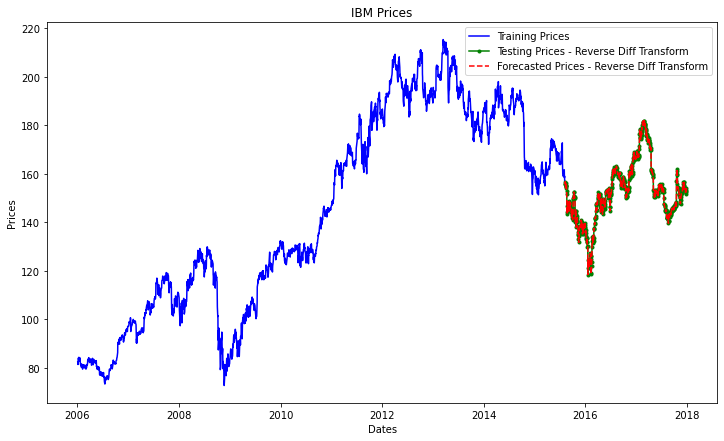

In [28]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(reverse_test_diff_series, color='green', marker='.', label='Testing Prices - Reverse Diff Transform')
plt.plot(reverse_test_diff_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Diff Transform')
plt.legend();

### Q10: Visualize only test and forecast prices

This analysis using ARIMA has performed pretty well in forecasting prices 

# Time Series Forecasting with Deep Learning

The approach uses sequential models, to be more specific - LSTMs, to build a deep learning model that predicts the 'Open' Stock prices of IBM over a period of two years by using data from the previous 10 years.

### LSTM: A brief overview

What are LSTMs? : https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

### Headers

In [ ]:
# Let's load the libraries and dependencies for the deep learning model
from sklearn.preprocessing import MinMaxScaler

%tensorflow_version 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

### Load Data

In [ ]:
df = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv")
df.isnull().values.any()
df = df.dropna()

df.index = pd.to_datetime(df['Date'])
df.head()

# Note
This dataset is composed of different features.we will just examine the "Open" stock prices feature. This same analysis can be repeated for most of the other features.

## Build Train-Test Datasets

In [ ]:
# Splitting the train and test set considering 'Open' feature from the dataset
train_data, test_data = df.iloc[0:int(len(df)*0.8), :], df.iloc[int(len(df)*0.8):, :]
train_series = train_data['Open']
test_series = test_data['Open']
train_series.shape, test_series.shape

### Q11: Visualize train and test price data

### Scaling
As stock prices can vary across a wide range, we scale the data to have zero mean and unit variance.

This is done to ensure that the gradient descent is sooner when learning a deep learning model

### Q12: Use the initialized min-max scaler to scale the prices in train_series

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
# START_CODE_HERE
training_set_scaled = <YOUR CODE HERE>
# END_CODE_HERE

In [ ]:
training_set_scaled.shape

### Train Data Preparation

Train data uses the previous 60 days (two months) data to predict the stock price of the next day.
The data is prepared just like a sliding window approach, where
*window_size = 60*

Sample image for sliding window:
![Sliding window](imgs/sliding_window.png)

In [ ]:
#1 output and 60 values inputs
# So for each element of training set (output), we have 60 previous training set elements (input)

X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

#### Reshape X_train

Now we reshape X_train in the format like:

(batch_size, timesteps, input_dim) => (m, features, $x_{i1}$)

The X_train should be now: (2709, 60, 1)

60 features = 60 day sliding window

$x_{i1}$ = 1 data point for each feature and i represents the feature



In [ ]:
# Reshaping X_train for efficient modeling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [ ]:
X_train.shape

### LSTM Regression model

We use  [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):
*   units - output dimensions
*   return_sequences is set to True to get all the hidden state vectors information

The model uses 2 LSTM layers followed by a Dense Layer with a single neuron to output regression prediction.

#### Similar Model Architecture (dimensions not exact)

![Similar Model Architecture](imgs/lstm.png)


### Q13: Build the LSTM based forecasting DL Model architecture

Hints:

    - Fill the second LSTM layer using an LSTM cell with 64 units, remember NOT to set return_sequences to True as we are only concerned about passing the last sequence output to the next layer
    - Fill the Output layer with 1 unit
    - Compile the model with mentioned optimizer and loss values

In [ ]:
regressor = Sequential()

# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second LSTM layer
<YOUR CODE HERE>

# The output layer
<YOUR CODE HERE>

# Compiling the RNN - optimizer(rmsprop)and loss(mean squared error)
<YOUR CODE HERE>

regressor.summary()

### Train the model

In [ ]:
regressor.fit(X_train,y_train, epochs=15, batch_size=64, validation_split=0.1, shuffle=False)

### Test Data Forecasting

#### Data Preparation:
Lets prepare the test data just like we did with the train data.

Remember to start forecasting on the first day of the test data, we need the last 60 days of train data.

Thus, the following steps have been performed so first 60 entires of test set have 60 previous values from the train dataset

### Q14: Get the last 60 records from train_series

In [ ]:
train_last60 = <YOUR CODE HERE>
print(train_last60.shape)
assert train_last60.shape == (60,), ("Oops! There is a data dimension mismatch error. Hint: Slice the last 60 records from train_series")

In [ ]:
test_series.shape

### Q15: Combine both train_last60 and test_series together 

Hint: Check pandas __`concat()`__

In [ ]:
new_test_series =  <YOUR CODE HERE>
print(new_test_series.shape)
assert new_test_series.shape == (664,), ("Oops! There is a data dimension mismatch error. Hint: Use pandas concat with the right axis parameter")

### Q16: Scale the test dataset (new_test_series) using the trained MinMaxScaler transformer - sc

Hint: Don't fit the scaler again here since it has already been trained

In [ ]:
test_set_scaled = <YOUR CODE HERE>

### Prepare Test dataset Windows of 60  days each

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(test_set_scaled)):
    X_test.append(test_set_scaled[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

### Model Prediction and Reverse Transform of Prices

In [ ]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price_revtrans = sc.inverse_transform(predicted_stock_price).ravel()
predicted_stock_price_revtrans_series = pd.Series(predicted_stock_price_revtrans)
predicted_stock_price_revtrans_series.index = test_series.index
predicted_stock_price_revtrans_series.shape, test_series.shape

## Model Evaluation

In [ ]:
# Evaluating our model
error = mean_squared_error(test_series, predicted_stock_price_revtrans_series)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_series, predicted_stock_price_revtrans_series)
print('Symmetric Mean absolute percentage error: %.3f' % error2)

## Visualizing the results from model predictions

### Visualize train, test and forecasted prices

In [ ]:
plt.figure(figsize=(12,7))
plt.title('IBM Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_series, color='blue', label='Training Prices')
plt.plot(test_series, color='green', label='Testing Prices')
plt.plot(predicted_stock_price_revtrans_series, color='red', linestyle='--', label='Forecasted Prices - Reverse Transform')
plt.legend();

### Q17: Visualize only test and forecast prices

# Conclusion

Remember we did a rolling point-based prediction for the ARIMA model where we tried to predict every day's (t) stock price in the test data by using both the training data as well as the previous (n - t) days of test data also to fit the model which gave it such good results vs. the LSTM model where we used 2 months of rolling window price data to predict the next day's price.